<h2><font size="3" color="#008B8B"><strong>Previsões com modelos de regressão</strong></font></h2>
<ul>
    <li><font size="2" color="lightblue"><strong>Modelos Utilizados</strong></font>:<font size="2" color="#1f77b4"> XGBoost, LightGBM, Regressão Linear, Random Forest Regressor e Decision Tree Regressor.</font></li>
    <li><font size="2" color="lightblue"><strong>Conjunto de Dados</strong></font>:<font size="2" color="#1f77b4"> Geração de energia do LDTEA com frequência horária (média dos medidores).</font></li>
    <li><font size="2" color="lightblue"><strong>Recursos Temporais (Time Features)</strong></font>:</li>
    <ul>
        <li><font size="2" color="#1f77b4">Hora do dia.</font></li>
        <li><font size="2" color="#1f77b4">Dia do mês.</font></li>
        <li><font size="2" color="#1f77b4">Dia da semana.</font></li>
        <li><font size="2" color="#1f77b4">Mês do ano.</font></li>
        <li><font size="2" color="#1f77b4">Final de semana.</font></li>
    </ul>
    <li><font size="2" color="lightblue"><strong>Abordagens de recursos relacionados ao tempo:</strong></font>:</li>
    <ul>
        <li><font size="2" color="#1f77b4">Variáveis ​​​​fictícias</font></li>
        <li><font size="2" color="#1f77b4">Codificação cíclica (seno/cosseno).</font></li>
        <li><font size="2" color="#1f77b4">Funções de base radial.</font></li>
    </ul>
</ul>

In [78]:
import pickle
import joblib
from pathlib import Path
import pandas as pd
import numpy as np
import itertools
from tqdm import tqdm
import time

from matplotlib import pyplot as plt
from matplotlib import rcParams
import matplotlib.dates as mdatesDateFormatter 
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

from sklego.preprocessing import RepeatingBasisFunction
from sklego.pandas_utils import add_lags

from sklearn.pipeline import Pipeline, make_pipeline, make_union
from sklearn.base import clone

from feature_engine.creation import CyclicalFeatures
from sktime.transformations.series.time_since import TimeSince

from cycler import cycler
from yellowbrick.regressor import PredictionError

from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor


In [79]:
# jupter notebook settings

dark_orange = "#FF8C00"
dark_blue = "#00008B"
dark_green = "#006400"
dark_cyan = "#008B8B"
dark_slate = "#2F4F4F"
dark_magenta = "#8B008B"
dark_red = "#8B0000"
dark_olive = "#556B2F"
crimson = "#DC143C"

yellow_green = "#9ACD32"
lime_green = "#32CD32"
golden_rod = "#DAA520"
dark_golden_rod = "#B8860B"
light_blue = "#AED6F1"
light_red = "#F1948A"
highlight_green = "green"
highlight_red = "red"

color_train = dark_cyan
color_test = "#1f77b4"
color_future = "#ff7f0e"
color_forecast = "#ff7f0e"
color_predict = yellow_green

rcParams['axes.prop_cycle'] = cycler(
    color=['navy', 'orange', 'k', 'b', 'y', 'pink', 'magenta', 'cyan', 'r', 'midnightblue']
)


In [80]:
# Constants:

TARGET = "ldtea"
DATE_COL = "date_time"
FREQUENCY = "H"

START_DATE = pd.to_datetime("2023-06-01 00:00:00")
SPLIT_DATE = pd.to_datetime("2023-09-15 23:59:59")
END_DATE = pd.to_datetime("2023-09-30 23:59:59")

TIME_FEATURES = [
    "hour",
    "day",
    "month",
    "day_of_week",
    "is_weekend",
    "is_night",
]

CYCLIC_FEATURES = [
    "hour_sin", 
    "hour_cos", 
    "day_sin", 
    "day_cos", 
    "day_of_week_sin", 
    "day_of_week_cos",
]

SINCE_FEATURES = [
    "time_since",
    "time_since_2",]

RADIAL_FEATURES = [
    "rbf_0",
    "rbf_1",
    "rbf_2",
    "rbf_3",
    "rbf_4",
    "rbf_5",
    "rbf_6",
    "rbf_7",
    "rbf_8",
    "rbf_9",
    "rbf_10",
    "rbf_11",
 ]


feature_sets = {
    "TF" : TIME_FEATURES,
    "CF" : CYCLIC_FEATURES,
    "SF" : SINCE_FEATURES,
    "RF" : RADIAL_FEATURES,
    "TC" : TIME_FEATURES + CYCLIC_FEATURES,
    "TR" : TIME_FEATURES + RADIAL_FEATURES,
    "TS" : TIME_FEATURES + SINCE_FEATURES,
    "CR" : CYCLIC_FEATURES + RADIAL_FEATURES,
    "CS" : CYCLIC_FEATURES + SINCE_FEATURES,
    "RS" : RADIAL_FEATURES + SINCE_FEATURES,
    "TCR" : TIME_FEATURES + CYCLIC_FEATURES + RADIAL_FEATURES,
    "TCS" : TIME_FEATURES + CYCLIC_FEATURES + SINCE_FEATURES,
    "TRS" : TIME_FEATURES + RADIAL_FEATURES + SINCE_FEATURES,
    "CRS" : CYCLIC_FEATURES + RADIAL_FEATURES + SINCE_FEATURES,
    "ALL" : TIME_FEATURES + CYCLIC_FEATURES + SINCE_FEATURES + RADIAL_FEATURES,
}

mapping_metrics = {
    "mae": "Mean Absolute Error",
    "mse": "Mean Squared Error",
    "r2": "R2 Score",
    "rmse": "Root Mean Squared Error",
    "mape": "Mean Absolute Percentage Error",
    "mdape": "Median Absolute Percentage Error",
    "smape": "Symmetric Mean Absolute Percentage Error",
}

xgb_params = {
    "booster": "gbtree",
    "learning_rate": 0.01,
    "max_depth": 2,
    "min_child_weight": 2,
    "base_score": 0.5,
    "n_estimators": 1500,
    "early_stopping_rounds": 50,
    "objective": "reg:squarederror",
    "subsample": 0.5,
}


In [81]:
# Funcoes auxiliares


def create_features(df):
    df = df.copy()
    df = add_time_features(df)
    df = add_time_since(df)
    df = add_cyclic_features(df)
    df = add_radial_basics_function(df)
    return df

def add_time_since(df):
    time_diff = df.index - df.index.min()
    
    df["time_since"] = time_diff.total_seconds() / 3600
    df["time_since_2"] = df["time_since"] ** 2
    return df

def add_time_features(df):
    df["hour"] = df.index.hour
    df["day"] = df.index.day
    df["day_of_week"] = df.index.weekday
    df["month"] = df.index.month
    df["is_weekend"] = df.day_of_week.isin([5, 6]).astype(int)
    df["is_night"] = ((df["hour"] >= 18) | (df["hour"] <= 6)).astype(int)
    return df


def add_cyclic_features(df, columns=None, drop_original=False):
    if columns is None:
        columns = ["hour", "day", "day_of_week"]

    for col in columns:
        freq = df[col].max() if df[col].min() != 0 else df[col].max() + 1
        df[f"{col}_sin"] = np.sin(df[col] * (2.0 * np.pi / freq))
        df[f"{col}_cos"] = np.cos(df[col] * (2.0 * np.pi / freq))

    if drop_original:
        df.drop(columns, axis=1, inplace=True)
    return df

def calc_irrad_lat_long(df):
    solar_declination = 23.45 * np.sin(np.deg2rad(360 * (284 + df.index.dayofyear) / 365))


def add_radial_basics_function(df):
    rbf = RepeatingBasisFunction(
        n_periods=12,
        column="hour",
        input_range=(0, 23),
        remainder="drop",
    )

    rbf.fit(df)
    df_rbf = pd.DataFrame(
        index=df.index,
        data=rbf.transform(df)
    )

    df_rbf.columns = [f"rbf_{col}" for col in df_rbf.columns if str(col).isdigit()]
    return pd.concat([df, df_rbf], axis=1)


# ---------------------------------------------------------------------------------------------------------------------

#MAPE (com descarte de valores quando y_true == 0)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (
        np.mean(np.abs((y_true[y_true != 0] - y_pred[y_true != 0]) / y_true[y_true != 0]))* 100)


# sMAPE
def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


# MASE
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    mae_model = mean_absolute_error(y_true, y_pred)

    try:
        hour_median_train = y_train.groupby(y_train.index.hour).median()
        mapped_values = y_true.index.hour.map(hour_median_train)
        mae_naive = mean_absolute_error(y_true, mapped_values)

        return 0 if mae_naive == 0 else mae_model / mae_naive

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

    return meam_error_model / mean_error_naive


def calculate_forecast_accuracy(y_true, y_pred, y_train):
    return {
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": mean_squared_error(y_true, y_pred, squared=False),
        "mse": mean_squared_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
        "mape": mean_absolute_percentage_error(y_true, y_pred),
        "smape": symmetric_mean_absolute_percentage_error(y_true, y_pred),
        "mase": mean_absolute_scaled_error(y_true, y_pred, y_train),
    }


def print_forecast_accuracy(y_true, y_pred, y_train, title):
    acc = calculate_forecast_accuracy(y_true, y_pred, y_train)

    print("\n" + "=" * 120)
    print(f"Resumo das métricas de precisão (forecast accuracy - {title})".center(120))
    print("=" * 120 + "\n")
    print(f"MAE : {acc['mae']:>8.2f} - As previsões, em média, estão {acc['mae']:0.2f} unidades distantes dos valores reais.")
    print(f"RMSE: {acc['rmse']:>8.2f} - O erro médio do seu modelo é de {acc['rmse']:0.2f} unidades em relação aos valores observados.")
    print(f"R²  : {acc['r2']:>8.2f} - O coeficiente de determinação R² é {acc['r2']:0.2f}.")
    print(f"MSE : {acc['mse']:>8.2f} - A média dos quadrados das diferenças entre os valores previstos e reais é {acc['mse']:0.2f}")
    print(f"MAPE: {acc['mape']:>7.2f}% - As previsões, em média, estão desviando em {acc['mape']:0.2f}% dos valores reais.")
    print(f"MASE: {acc['mase']:>7.2f} - O erro médio do seu modelo é {acc['mase']:0.2f} vezes maior que o erro médio do modelo Naive Lag.")
    print("=" * 120 + "\n")

# ----------------------------------------------------------------------------------------------------------------------------

def get_tuning_hyperparameter(model, params, X_train, y_train, cv=5):
    score = "neg_root_mean_squared_error"

    grid_search = RandomizedSearchCV(
        model,
        params,
        scoring=score,
        n_iter=10,
    )
    grid_search.fit(X_train, y_train)

    return grid_search


def plot_forecast(df, model, start=None, end=None, span=False):
    df_plot = df[start:end] if start and end else df.copy()
    plt.figure(figsize=(24, 5))

    colors = sns.color_palette("bright")

    for col in df_plot.columns:
        params = {
            "train": {"label": "Train set", "color": color_train, "lw": 2.5, "ls": "-", "alpha": 0.8},
            "test": {"label": "Test set", "color": color_test, "lw": 2.5, "ls": "-", "alpha": 0.8},
            "xgb_pred": {"label": "Predict (XGBoost)", "color": color_forecast, "lw": 2.5, "ls": "-", "alpha": 0.8},
            "lgb_pred": {"label": "Predict (LightGBM)", "color": colors[2], "lw": 2.5, "ls": "-", "alpha": 0.8},
            "lr_pred": {"label": "Predict (Linear Reg)", "color": colors[3], "lw": 2.5, "ls": "-", "alpha": 0.8},
            "rfr_pred": {"label": "Predict (Random Forest)", "color": colors[6], "lw": 2.5, "ls": "-", "alpha": 0.8},
            "dtr_pred": {"label": "Predict (Decision Tree)", "color": colors[5], "lw": 2.5, "ls": "-", "alpha": 0.8},
        }.get(col, {"label": None, "color": None, "lw": None})

        if all(params.values()):
            plt.plot(
                df_plot.index, 
                df_plot[col], 
                label=params["label"], 
                color=params["color"], 
                lw=params["lw"], 
                ls=params["ls"],
                alpha=params["alpha"],
            )
        
        if span:
            df_span = df_plot[df_plot["test"].notnull()]["test"]
            plt.axvspan(df_span.index.min(), df_span.index.max(), color=light_blue, alpha=0.08)

    plt.title(f"{model} - Predict Test set", fontsize=16, fontweight="bold", pad=20)
    plt.ylabel("KWh", fontsize=16, labelpad=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y", alpha=0.5, linewidth=1.2)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    plt.legend(
        loc="upper left",
        fontsize=16,
        frameon=True,
        shadow=True,
        framealpha=1,
        facecolor="white",
        bbox_to_anchor=(1, 1),
    )
    plt.tight_layout()
    plt.show()


def plot_feature_importances(feature_importance, model, lower_bound=0.1, column="importance"):
    fi = feature_importance[[column]].copy()
    fi.dropna(inplace=True)
    fi["percentage"] = (fi[column] / fi[column].sum()) * 100
    fi = fi[fi["percentage"] > lower_bound].sort_values(by=column, ascending=False)

    num_rows = fi.shape[0]
    colors = sns.color_palette("deep", num_rows)
    max_value = fi["percentage"].max() / 100

    plt.figure(figsize=(16, max(num_rows * 0.6, 16/num_rows * 1.15)))
    ax = sns.barplot(
        x="percentage",
        y=fi.index,
        data=fi,
        palette=colors,
        width=0.8,
    )

    for p in ax.patches:
        width = p.get_width()
        offset = 4 * max_value if width < 3 else - 0.2
        plt.text(
            width + offset,
            p.get_y() + p.get_height() / 2,
            f"{width:.1f}%",
            ha="right",
            va="center",
            fontsize=12,
        )

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13, rotation=0)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.xlabel("Importância (%)", fontsize=11, labelpad=20)
    plt.title(f"Importância dos recursos ({model})", fontsize=13, pad=10)
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------------------------------------------------------------

def save_model(model, name, mode="pkl"):
    model_path = Path.cwd().parent / "models"
    model_path.mkdir(parents=True, exist_ok=True)
    file_path = model_path / f"{name}.{mode}"
    
    match mode:
        case "joblib":
            joblib.dump(model, file_path)
        case "pkl":
            with open(file_path, 'wb') as file:
                pickle.dump(model, file)
        case "xgb":
            model.save_model(file_path)
        case "xgb" | "lgb":
            model.save_model(file_path)
        case _:
            raise ValueError(f"Invalid mode: {mode}")
    
    print(f"Modelo <{file_path.stem}{file_path.suffix}> salvo com sucesso!")

def load_model(name, mode="pkl"):
    model_path = Path.cwd().parent / "models"
    file_path = model_path / f"{name}.{mode}"
    
    match mode:
        case "joblib":
            model = joblib.load(file_path)
        case "pkl":
            with open(file_path, 'rb') as file:
                return pickle.load(file)
        case "xgb":
            model = xgb.load_model(file_path)
        case "lgb":
            model = lgb.load_model(file_path)
        case _:
            raise ValueError(f"Invalid mode: {mode}")

    print(f"Modelo <{file_path.stem}.{file_path.suffix}> carregado com sucesso!")
    return model


In [82]:
# Carregar dados de producao de energia (freq 1H).

file_path = "../data/2.1_hourly_production_cleaned.csv"

df_raw = pd.read_csv(file_path, parse_dates=[DATE_COL], index_col=DATE_COL)
df_raw.sort_index(inplace=True)
df_raw = df_raw.asfreq(FREQUENCY)

print(f"df_raw: {df_raw.index.min()} - {df_raw.index.max()}")
print(f"shape : {df_raw.shape}")
print(f"freq  : {df_raw.index.freq}")
display(df_raw.head())


df_raw: 2023-06-01 00:00:00 - 2023-10-06 23:00:00
shape : (3072, 6)
freq  : <Hour>


LDTEA 1  LDTEA 2  LDTEA 3  LDTEA 4  UAC 2  UAC 3
date_time                                                            
2023-06-01 00:00:00      0.0      0.0      0.0      0.0    0.0    0.0
2023-06-01 01:00:00      0.0      0.0      0.0      0.0    0.0    0.0
2023-06-01 02:00:00      0.0      0.0      0.0      0.0    0.0    0.0
2023-06-01 03:00:00      0.0      0.0      0.0      0.0    0.0    0.0
2023-06-01 04:00:00      0.0      0.0      0.0      0.0    0.0    0.0

In [83]:
# Agrupar LDTEA e UAC e dividir os dados em base e validação (TARGET = "ldtea")

df_agg = pd.DataFrame()
df_agg[TARGET] = df_raw[["LDTEA 1", "LDTEA 2", "LDTEA 3", "LDTEA 4"]].mean(axis=1)

df = create_features(df_agg)
df_base = df.loc[START_DATE:END_DATE].copy()
df_eval = df.loc[END_DATE:].copy()

print(f"df_base: {df_base.shape} | {df_base.index.min()} - {df_base.index.max()}")
print(f"df_eval: {df_eval.shape}  | {df_eval.index.min()} - {df_eval.index.max()}")
df_base.head()


df_base: (2928, 27) | 2023-06-01 00:00:00 - 2023-09-30 23:00:00
df_eval: (144, 27)  | 2023-10-01 00:00:00 - 2023-10-06 23:00:00


ldtea  hour  day  day_of_week  month  is_weekend  \
date_time                                                               
2023-06-01 00:00:00    0.0     0    1            3      6           0   
2023-06-01 01:00:00    0.0     1    1            3      6           0   
2023-06-01 02:00:00    0.0     2    1            3      6           0   
2023-06-01 03:00:00    0.0     3    1            3      6           0   
2023-06-01 04:00:00    0.0     4    1            3      6           0   

                     is_night  time_since  time_since_2  hour_sin  ...  \
date_time                                                          ...   
2023-06-01 00:00:00         1         0.0           0.0  0.000000  ...   
2023-06-01 01:00:00         1         1.0           1.0  0.258819  ...   
2023-06-01 02:00:00         1         2.0           4.0  0.500000  ...   
2023-06-01 03:00:00         1         3.0           9.0  0.707107  ...   
2023-06-01 04:00:00         1         4.0          16.0  0.866025  ...   

                        rbf_2     rbf_3         rbf_4         rbf_5  \
date_time                                                             
2023-06-01 00:00:00  0.018316  0.000123  1.125352e-07  1.388794e-11   
2023-06-01 01:00:00  0.112449  0.002151  5.568980e-06  1.951202e-09   
2023-06-01 02:00:00  0.400543  0.021754  1.598906e-04  1.590473e-07   
2023-06-01 03:00:00  0.827757  0.127632  2.663361e-03  7.521601e-06   
2023-06-01 04:00:00  0.992467  0.434461  2.573932e-02  2.063736e-04   

                            rbf_6         rbf_7         rbf_8         rbf_9  \
date_time                                                                     
2023-06-01 00:00:00  2.319523e-16  1.388794e-11  1.125352e-07  1.234098e-04   
2023-06-01 01:00:00  9.252087e-14  5.735003e-14  1.319352e-09  4.107703e-06   
2023-06-01 02:00:00  2.141118e-11  3.900912e-16  8.974149e-12  7.932469e-08   
2023-06-01 03:00:00  2.874760e-09  1.486976e-13  3.541487e-14  8.887458e-10   
2023-06-01 04:00:00  2.239352e-07  3.288527e-11  6.535693e-16  5.777057e-12   

                           rbf_10    rbf_11  
date_time                                    
2023-06-01 00:00:00  1.831564e-02  0.367879  
2023-06-01 01:00:00  1.730806e-03  0.098698  
2023-06-01 02:00:00  9.489307e-05  0.015363  
2023-06-01 03:00:00  3.018426e-06  0.001387  
2023-06-01 04:00:00  5.570401e-08  0.000073  

[5 rows x 27 columns]

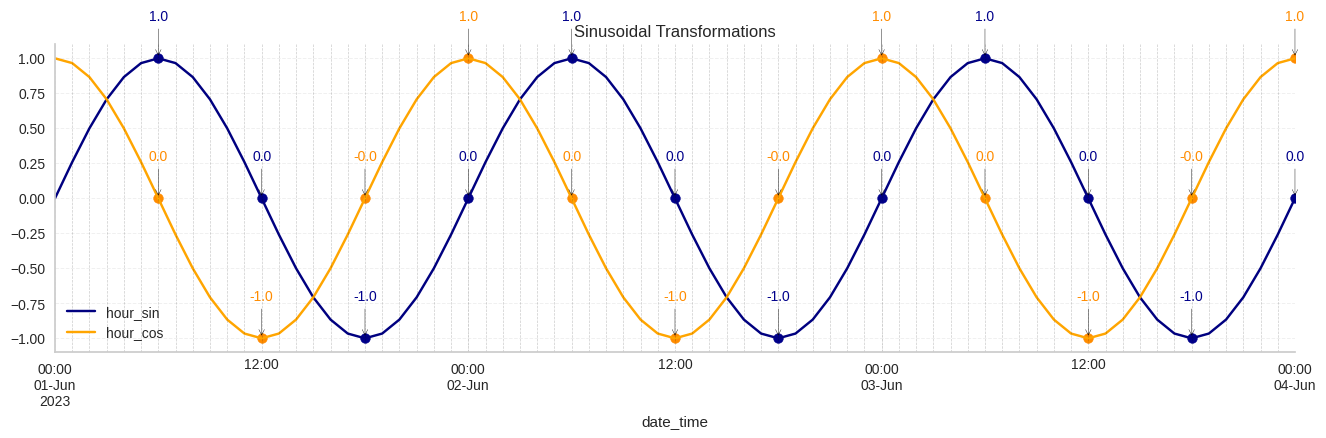

In [84]:

fig, ax = plt.subplots(figsize=(16, 4))
df_base.head(73).plot(y=["hour_sin", "hour_cos"], ax=ax, title="Sinusoidal Transformations", grid=True)

for idx in df_base[1:73].index:
    ax.axvline(idx, color="black", linestyle="--", alpha=0.2, lw=0.5)
    
    if idx.hour % 6 == 0:
        ax.scatter(idx, df_base.loc[idx, "hour_sin"], color=dark_blue, s=50)
        ax.scatter(idx, df_base.loc[idx, "hour_cos"], color=dark_orange, s=50)
        ax.annotate(
            f"{df_base.loc[idx, 'hour_sin'].round(4)}",
            xy=(idx, df_base.loc[idx, "hour_sin"]),
            xytext=(idx, df_base.loc[idx, "hour_sin"] + 0.3),
            ha="center",
            va="center",
            fontsize=10,
            color=dark_blue,
            arrowprops=dict(facecolor="green", arrowstyle="->"),
        )
        ax.annotate(
            f"{df_base.loc[idx, 'hour_cos'].round(4)}",
            xy=(idx, df_base.loc[idx, "hour_cos"]),
            xytext=(idx, df_base.loc[idx, "hour_cos"] + 0.3),
            ha="center",
            va="center",
            fontsize=10,
            color=dark_orange,
            arrowprops=dict(facecolor="green", arrowstyle="->"),
        )
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.3, lw=0.7, ls="--")
plt.grid(axis="x", alpha=0.3, lw=0.7, ls="--")

plt.show()


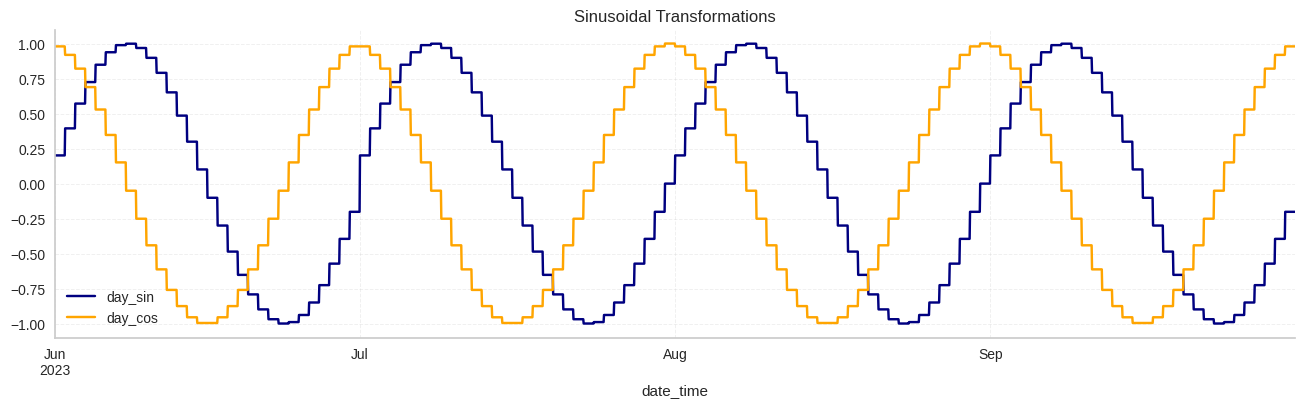

In [85]:
fig, ax = plt.subplots(figsize=(16, 4))
df_base.plot(y=["day_sin", "day_cos"], ax=ax, title="Sinusoidal Transformations", grid=True)
    
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.3, lw=0.7, ls="--")
plt.grid(axis="x", alpha=0.3, lw=0.7, ls="--")
plt.show()


In [86]:
df_base.describe()


ldtea         hour          day  day_of_week        month  \
count  2928.000000  2928.000000  2928.000000  2928.000000  2928.000000   
mean      5.303645    11.500000    15.754098     3.024590     7.500000   
std       7.238303     6.923369     8.808461     1.985791     1.110868   
min       0.000000     0.000000     1.000000     0.000000     6.000000   
25%       0.000000     5.750000     8.000000     1.000000     7.000000   
50%       0.066250    11.500000    16.000000     3.000000     7.500000   
75%      10.753125    17.250000    23.000000     5.000000     8.000000   
max      24.660000    23.000000    31.000000     6.000000     9.000000   

        is_weekend     is_night   time_since  time_since_2      hour_sin  ...  \
count  2928.000000  2928.000000  2928.000000  2.928000e+03  2.928000e+03  ...   
mean      0.286885     0.541667  1463.500000  2.856264e+06  4.853434e-18  ...   
std       0.452385     0.498346   845.385119  2.555648e+06  7.072276e-01  ...   
min       0.000000     0.000000     0.000000  0.000000e+00 -1.000000e+00  ...   
25%       0.000000     0.000000   731.750000  5.354582e+05 -7.071068e-01  ...   
50%       0.000000     1.000000  1463.500000  2.141832e+06  6.123234e-17  ...   
75%       1.000000     1.000000  2195.250000  4.819123e+06  7.071068e-01  ...   
max       1.000000     1.000000  2927.000000  8.567329e+06  1.000000e+00  ...   

              rbf_2         rbf_3         rbf_4         rbf_5         rbf_6  \
count  2.928000e+03  2.928000e+03  2.928000e+03  2.928000e+03  2.928000e+03   
mean   1.423133e-01  1.415553e-01  1.415501e-01  1.415501e-01  1.415501e-01   
std    2.826292e-01  2.829850e-01  2.829876e-01  2.829876e-01  2.829876e-01   
min    1.813914e-15  1.090875e-15  6.535693e-16  3.900912e-16  2.319523e-16   
25%    9.931402e-09  6.962952e-09  4.957224e-09  1.471623e-09  2.161422e-09   
50%    3.967087e-04  1.234098e-04  8.900330e-05  1.099698e-04  1.377427e-04   
75%    7.704245e-02  7.421020e-02  7.251366e-02  7.190422e-02  7.233228e-02   
max    9.924671e-01  9.831307e-01  9.702071e-01  9.538403e-01  9.342110e-01   

              rbf_7         rbf_8         rbf_9        rbf_10        rbf_11  
count  2.928000e+03  2.928000e+03  2.928000e+03  2.928000e+03  2.928000e+03  
mean   1.415501e-01  1.415501e-01  1.415553e-01  1.423133e-01  1.568784e-01  
std    2.829876e-01  2.829876e-01  2.829850e-01  2.826292e-01  2.848629e-01  
min    3.900912e-16  6.535693e-16  1.090875e-15  1.813914e-15  3.004806e-15  
25%    1.471623e-09  4.957224e-09  6.962952e-09  9.931402e-09  1.424232e-08  
50%    1.099698e-04  8.900330e-05  1.234098e-04  3.967087e-04  4.770331e-04  
75%    7.190422e-02  7.251366e-02  7.421020e-02  7.704245e-02  1.507300e-01  
max    9.538403e-01  9.702071e-01  9.831307e-01  9.924671e-01  9.981114e-01  

[8 rows x 27 columns]

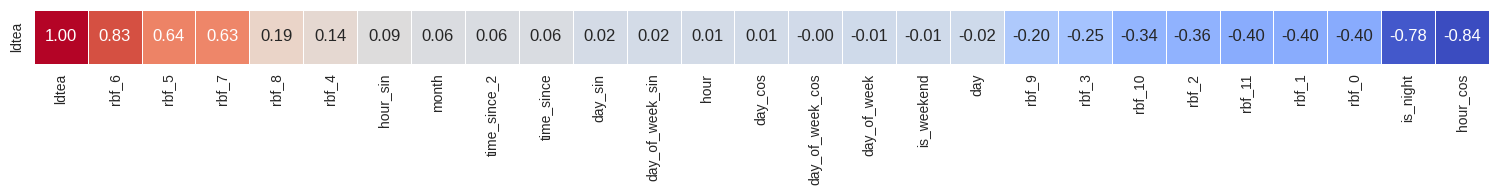

In [87]:
corr = df_base.corr()[[TARGET]].sort_values(by=TARGET, ascending=False)
corr = corr.T

plt.figure(figsize=(22, 0.7))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True, cbar=False)
plt.show()


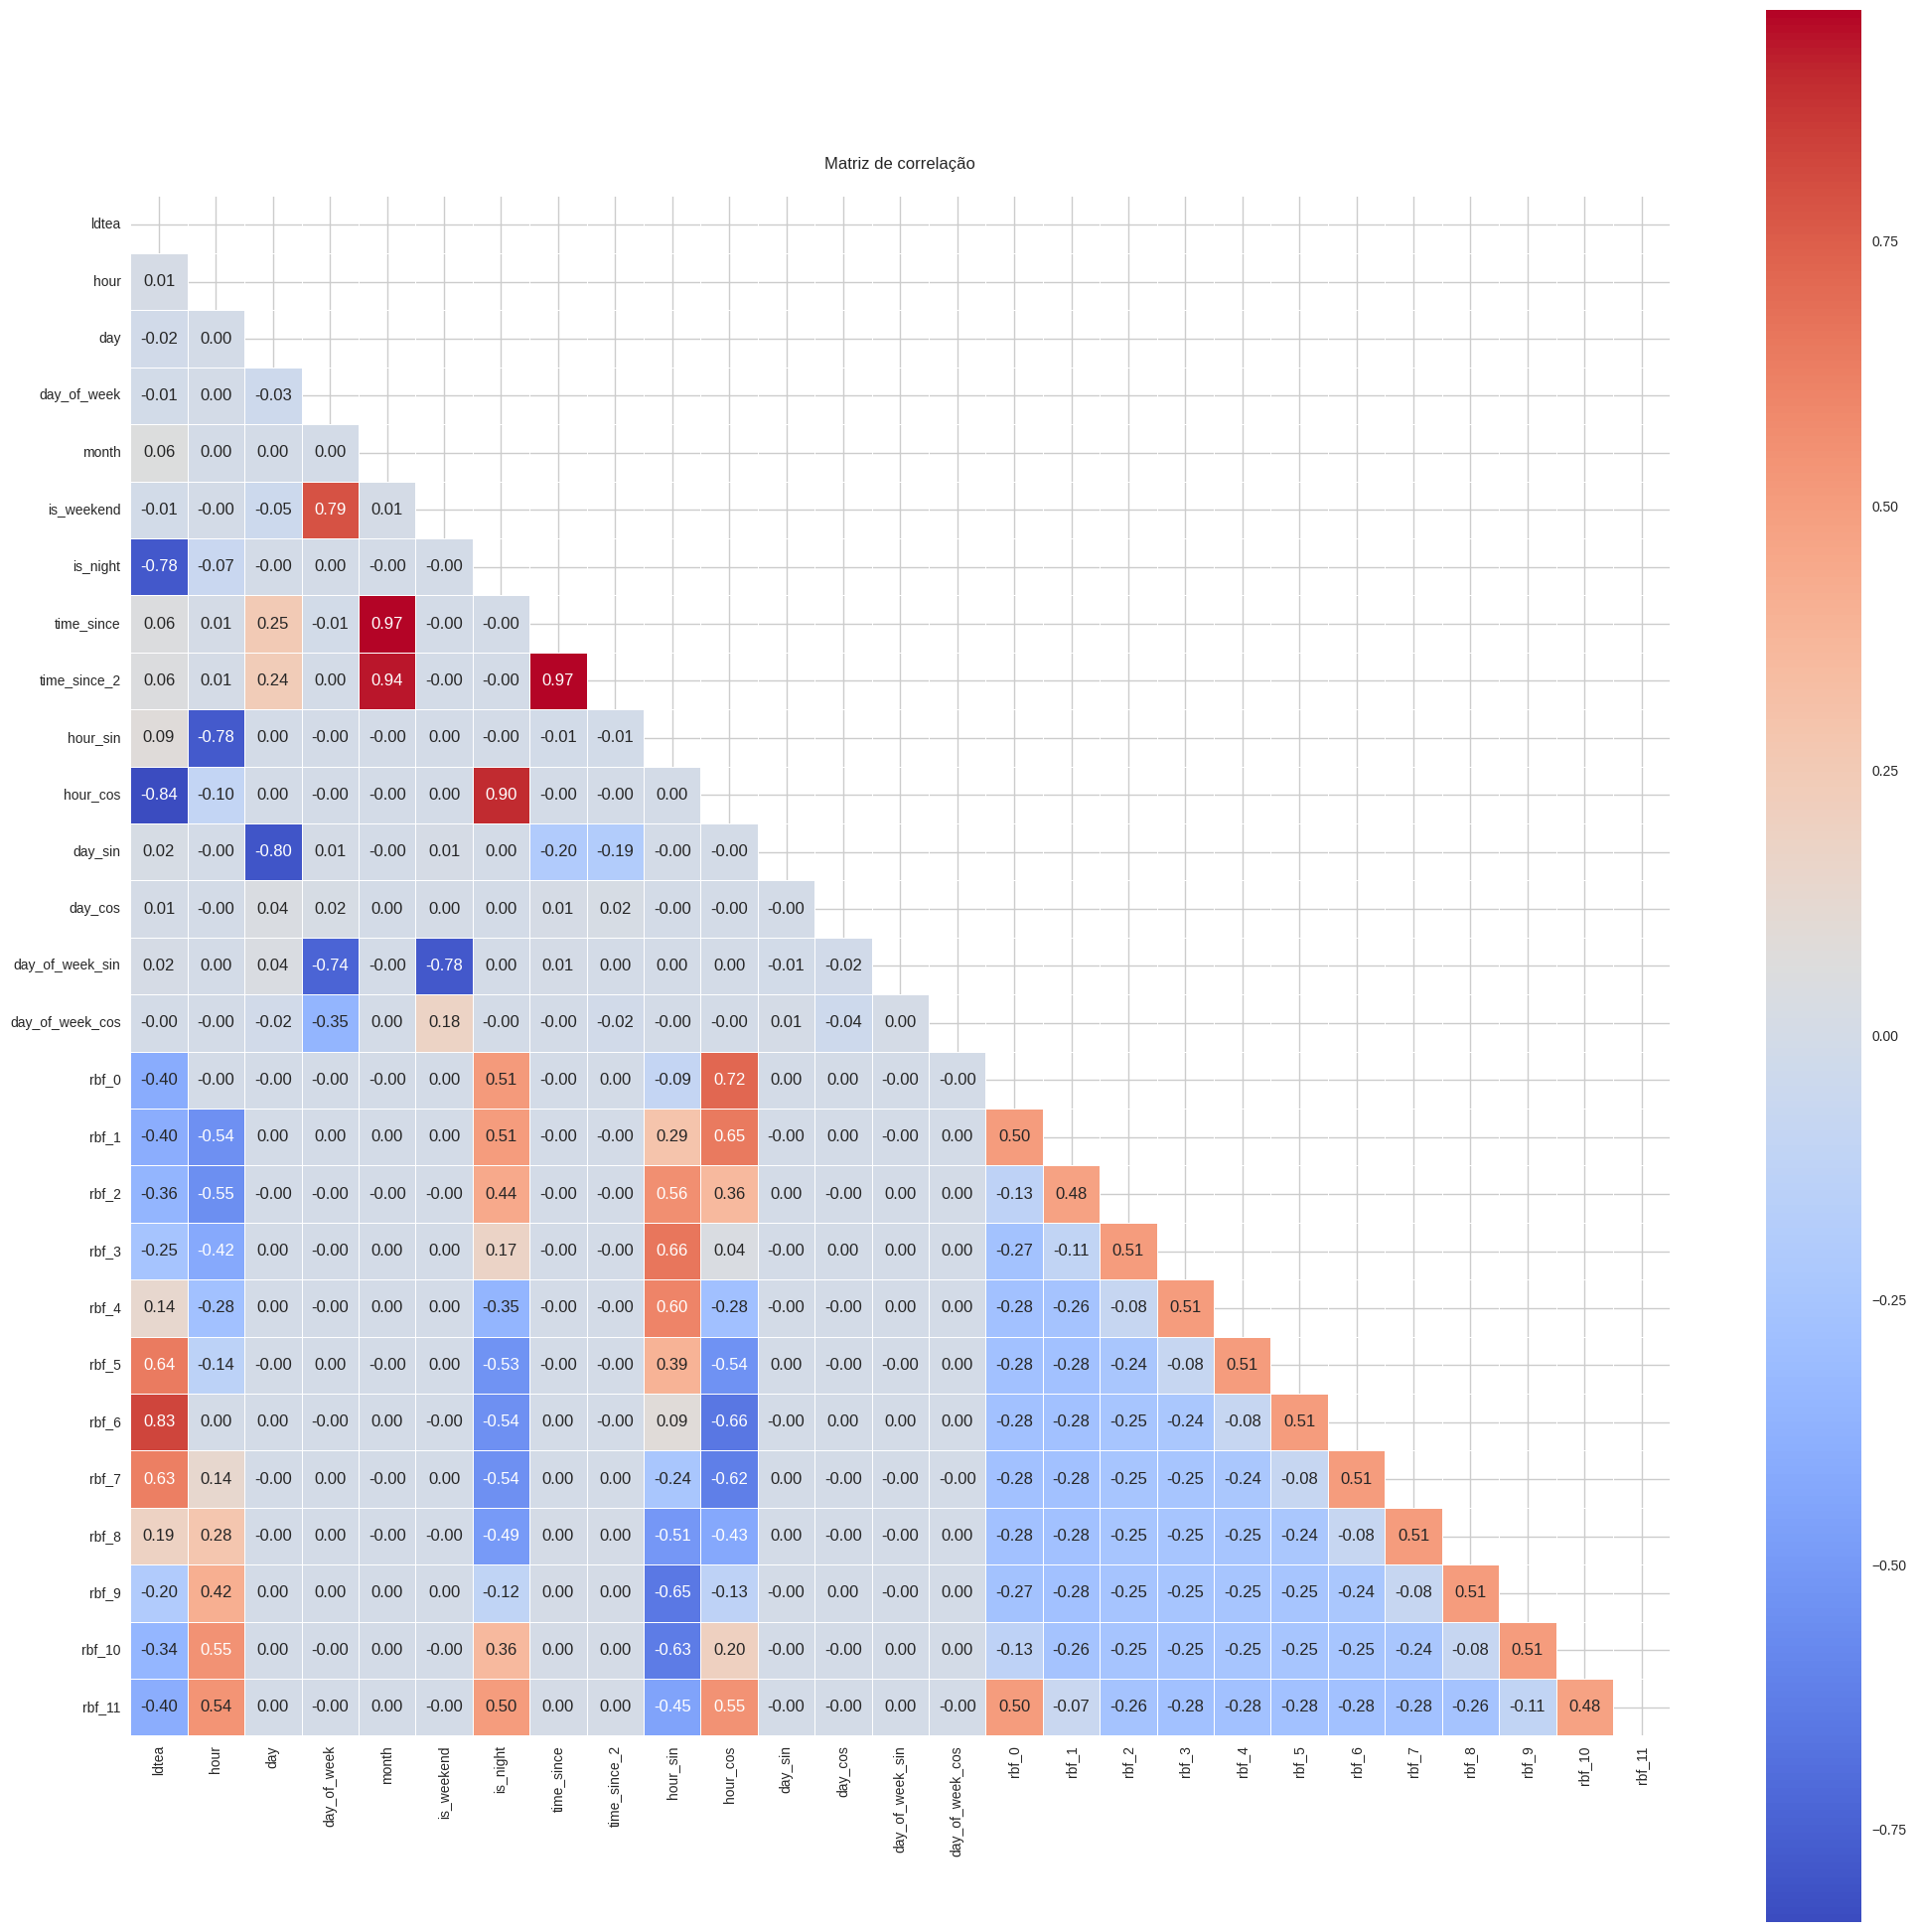

In [88]:
# Matriz de correlacao entre target e features

corr = df_base.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 25))
sns.heatmap(
    corr, 
    mask=mask,
    fmt=".2f",
    cbar=True, 
    annot=True, 
    cmap="coolwarm",
    linewidths=0.5,
    square=True,
)
plt.title("Matriz de correlação", pad=20)
plt.show()



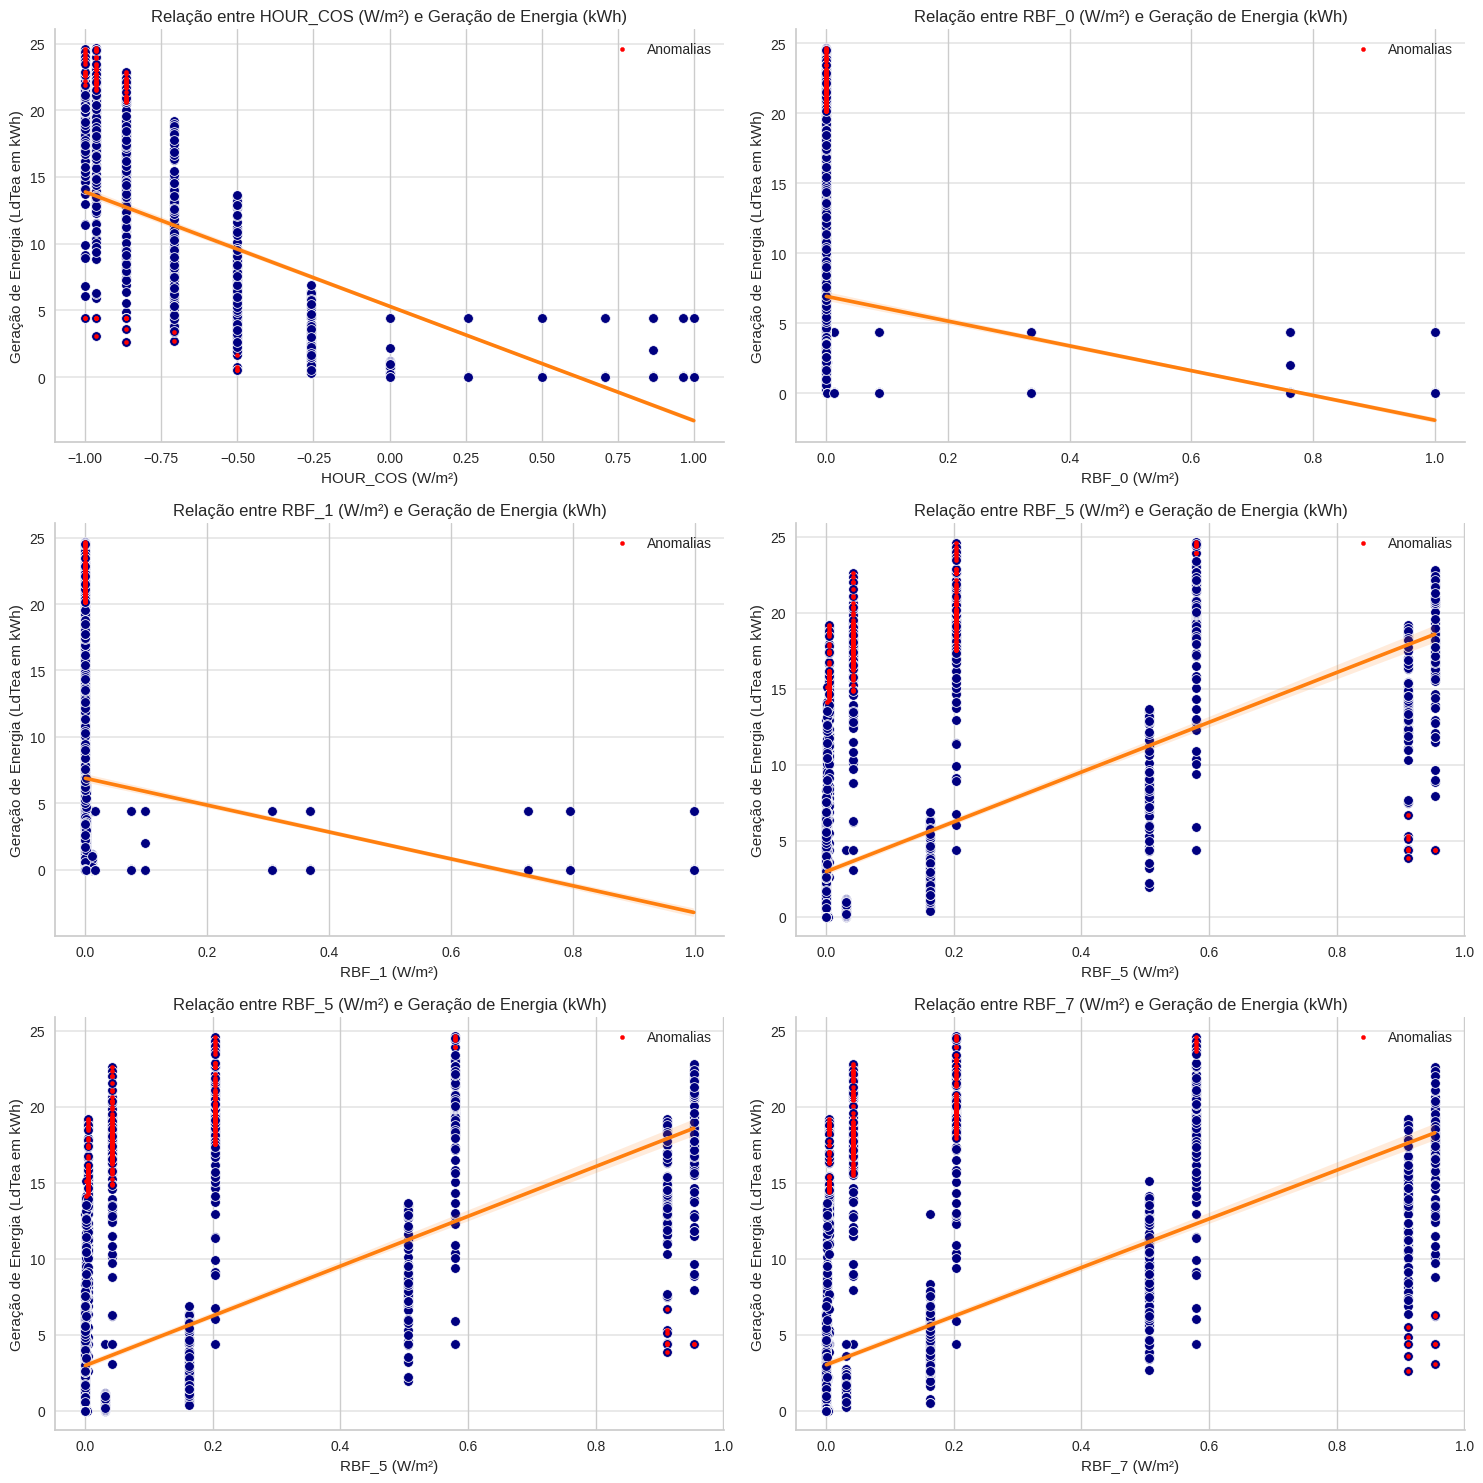

In [89]:
columns = ["hour_cos", "rbf_0", "rbf_1", "rbf_5", "rbf_5", "rbf_7"]

fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(columns):
    sns.scatterplot(data=df_base, x=col, y="ldtea", ax=axes[i])
    sns.regplot(x=col, y="ldtea", data=df_base, scatter=False, color=color_forecast, ax=axes[i])

    # Identificando e destacando anomalias
    modelo = np.polyfit(df_base[col], df_base['ldtea'], 1)
    df_base['pred'] = np.polyval(modelo, df_base[col])
    df_base['residuo'] = df_base['ldtea'] - df_base['pred']

    # Definindo um limite para considerar um ponto como anômalo
    limite_residuo = df_base['residuo'].std() * 2
    anomalias = df_base[abs(df_base['residuo']) > limite_residuo]

    axes[i].scatter(anomalias[col], anomalias['ldtea'], color="red", label="Anomalias", s=9)
    
    axes[i].set_title(f"Relação entre {col.upper()} (W/m²) e Geração de Energia (kWh)")
    axes[i].set_xlabel(f"{col.upper()} (W/m²)")
    axes[i].set_ylabel("Geração de Energia (LdTea em kWh)")
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)
    axes[i].grid(axis="y", alpha=0.5, linewidth=1.2)
    axes[i].legend(loc='upper right')

plt.tight_layout()
plt.show()


In [90]:
# Dividir dataframe base (treino e teste)

df_train = df_base.loc[:SPLIT_DATE]
df_test = df_base.loc[SPLIT_DATE:]

print(f"df_train: {df_train.index.min()} - {df_train.index.max()}")
display(df_train.head(3))
print(f"\ndf_test : {df_test.index.min()} - {df_test.index.max()}")
display(df_test.head(3))


df_train: 2023-06-01 00:00:00 - 2023-09-15 23:00:00


ldtea  hour  day  day_of_week  month  is_weekend  \
date_time                                                               
2023-06-01 00:00:00    0.0     0    1            3      6           0   
2023-06-01 01:00:00    0.0     1    1            3      6           0   
2023-06-01 02:00:00    0.0     2    1            3      6           0   

                     is_night  time_since  time_since_2  hour_sin  ...  \
date_time                                                          ...   
2023-06-01 00:00:00         1         0.0           0.0  0.000000  ...   
2023-06-01 01:00:00         1         1.0           1.0  0.258819  ...   
2023-06-01 02:00:00         1         2.0           4.0  0.500000  ...   

                            rbf_4         rbf_5         rbf_6         rbf_7  \
date_time                                                                     
2023-06-01 00:00:00  1.125352e-07  1.388794e-11  2.319523e-16  1.388794e-11   
2023-06-01 01:00:00  5.568980e-06  1.951202e-09  9.252087e-14  5.735003e-14   
2023-06-01 02:00:00  1.598906e-04  1.590473e-07  2.141118e-11  3.900912e-16   

                            rbf_8         rbf_9    rbf_10    rbf_11      pred  \
date_time                                                                       
2023-06-01 00:00:00  1.125352e-07  1.234098e-04  0.018316  0.367879  3.039893   
2023-06-01 01:00:00  1.319352e-09  4.107703e-06  0.001731  0.098698  3.039893   
2023-06-01 02:00:00  8.974149e-12  7.932469e-08  0.000095  0.015363  3.039893   

                      residuo  
date_time                      
2023-06-01 00:00:00 -3.039893  
2023-06-01 01:00:00 -3.039893  
2023-06-01 02:00:00 -3.039893  

[3 rows x 29 columns]


df_test : 2023-09-16 00:00:00 - 2023-09-30 23:00:00


ldtea  hour  day  day_of_week  month  is_weekend  \
date_time                                                               
2023-09-16 00:00:00    0.0     0   16            5      9           1   
2023-09-16 01:00:00    0.0     1   16            5      9           1   
2023-09-16 02:00:00    0.0     2   16            5      9           1   

                     is_night  time_since  time_since_2  hour_sin  ...  \
date_time                                                          ...   
2023-09-16 00:00:00         1      2568.0     6594624.0  0.000000  ...   
2023-09-16 01:00:00         1      2569.0     6599761.0  0.258819  ...   
2023-09-16 02:00:00         1      2570.0     6604900.0  0.500000  ...   

                            rbf_4         rbf_5         rbf_6         rbf_7  \
date_time                                                                     
2023-09-16 00:00:00  1.125352e-07  1.388794e-11  2.319523e-16  1.388794e-11   
2023-09-16 01:00:00  5.568980e-06  1.951202e-09  9.252087e-14  5.735003e-14   
2023-09-16 02:00:00  1.598906e-04  1.590473e-07  2.141118e-11  3.900912e-16   

                            rbf_8         rbf_9    rbf_10    rbf_11      pred  \
date_time                                                                       
2023-09-16 00:00:00  1.125352e-07  1.234098e-04  0.018316  0.367879  3.039893   
2023-09-16 01:00:00  1.319352e-09  4.107703e-06  0.001731  0.098698  3.039893   
2023-09-16 02:00:00  8.974149e-12  7.932469e-08  0.000095  0.015363  3.039893   

                      residuo  
date_time                      
2023-09-16 00:00:00 -3.039893  
2023-09-16 01:00:00 -3.039893  
2023-09-16 02:00:00 -3.039893  

[3 rows x 29 columns]

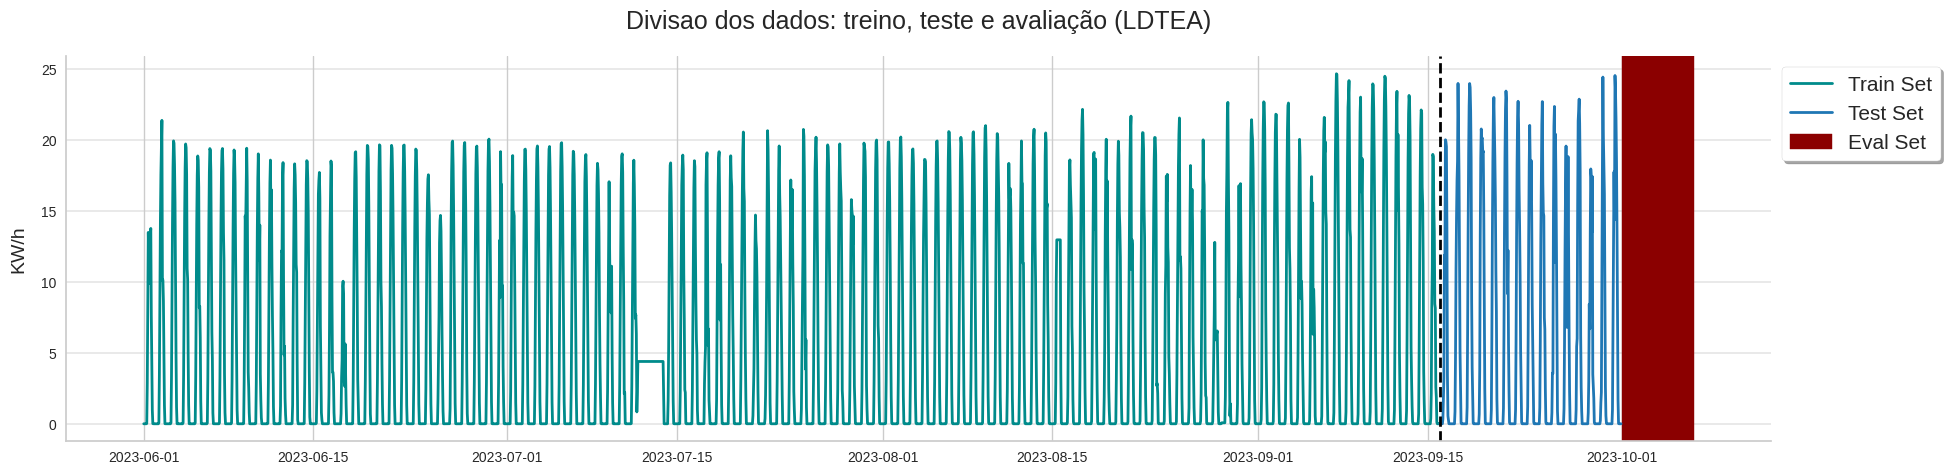

In [91]:
plt.figure(figsize=(22, 5))
plt.plot(df_train.index, df_train[TARGET], lw=2, color=color_train, label="Train Set")
plt.plot(df_test.index, df_test[TARGET], lw=2, color=color_test, label="Test Set")
plt.plot(df_eval.index, df_eval[TARGET], lw=0.0, color="red")

plt.xlabel("")
plt.ylabel("KW/h", fontsize=14, labelpad=10)
plt.title("Divisao dos dados: treino, teste e avaliação (LDTEA)", fontsize=18, pad=20)

plt.axvline(SPLIT_DATE, color="black", lw=2, linestyle="--")
plt.axvspan(END_DATE, df_agg.index.max(), alpha=1, color=dark_red, label="Eval Set")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)

plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.show()


In [92]:
# Preparar serie temporal para previsão (treino e teste)
# X = feature_sets
#   "TF"  : TIME_FEATURES,
#   "CF"  : CYCLIC_FEATURES,
#   "SF"  : SINCE_FEATURES,
#   "RF"  : RADIAL_FEATURES,
#   "TC"  : TIME_FEATURES   + CYCLIC_FEATURES,
#   "TR"  : TIME_FEATURES   + RADIAL_FEATURES,
#   "TS"  : TIME_FEATURES   + SINCE_FEATURES,
#   "CR"  : CYCLIC_FEATURES + RADIAL_FEATURES,
#   "CS"  : CYCLIC_FEATURES + SINCE_FEATURES,
#   "RS"  : RADIAL_FEATURES + SINCE_FEATURES,
#   "TCR" : TIME_FEATURES   + CYCLIC_FEATURES + RADIAL_FEATURES,
#   "TCS" : TIME_FEATURES   + CYCLIC_FEATURES + SINCE_FEATURES,
#   "TRS" : TIME_FEATURES   + RADIAL_FEATURES + SINCE_FEATURES,
#   "CRS" : CYCLIC_FEATURES + RADIAL_FEATURES + SINCE_FEATURES,
#   "ALL" : TIME_FEATURES   + CYCLIC_FEATURES + SINCE_FEATURES + RADIAL_FEATURES,
# y = target (ldtea)

X_train = [df_train[features] for features in feature_sets.values()]
y_train = df_train[[TARGET]]

X_test = [df_test[features] for features in feature_sets.values()]
y_test = df_test[[TARGET]]

print("X_train Features:")
print(f"X_train: {X_train[0].shape} | {X_train[0].index.min()} - {X_train[0].index.max()}")
display(X_train[0].head(3), y_train.head(3))


X_train Features:
X_train: (2568, 6) | 2023-06-01 00:00:00 - 2023-09-15 23:00:00


hour  day  month  day_of_week  is_weekend  is_night
date_time                                                               
2023-06-01 00:00:00     0    1      6            3           0         1
2023-06-01 01:00:00     1    1      6            3           0         1
2023-06-01 02:00:00     2    1      6            3           0         1

ldtea
date_time                 
2023-06-01 00:00:00    0.0
2023-06-01 01:00:00    0.0
2023-06-01 02:00:00    0.0

-----
#### XGBoost Regressor

In [93]:
# Definir modelo XGBoost base (parametros default) e treinar

# xgb_model = xgb.XGBRegressor(eval_metric="mae", **xgb_params)
xgb_model = xgb.XGBRegressor(eval_metric="mae")

df_pred = df_test[[TARGET]].rename(columns={TARGET: "test"}).copy()
performance_models = []
all_feature_importances = []
all_predictions = []

start_time = time.time()
for i in tqdm(range(len(X_train)), desc="Training Progress"):

    xgb_model.fit(
        X_train[i],
        y_train,
        eval_set=[(X_train[i], y_train), (X_test[i], y_test)],
        verbose=0,
    )
    
    y_pred= xgb_model.predict(X_test[i])
    all_predictions.append(y_pred)

    fi_df = pd.DataFrame(
        data=xgb_model.feature_importances_,
        index=xgb_model.feature_names_in_,
        columns=["importance"],
    )
    all_feature_importances.append(fi_df)
    
    predictions_accuracy = calculate_forecast_accuracy(df_test[TARGET], y_pred, y_train[TARGET])
    performance_models.append(predictions_accuracy)

idx_best = np.argmin([metric["mae"] for metric in performance_models])
df_pred["xgb_pred"] = all_predictions[idx_best]

feature_importances_ = pd.concat(all_feature_importances, axis="columns")
feature_importances_.columns = feature_sets.keys()
performance_models_ = pd.DataFrame(performance_models, index=feature_sets.keys())
best_features_importance = all_feature_importances[idx_best].sort_values(by="importance", ascending=False)

best_feature_set_key = list(feature_sets.keys())[idx_best]
print_forecast_accuracy(df_pred["test"], df_pred["xgb_pred"], y_train[TARGET], f"{xgb_model.__module__} - {best_feature_set_key}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")



Training Progress: 100%|██████████| 15/15 [00:03<00:00,  3.98it/s]


                       Resumo das métricas de precisão (forecast accuracy - xgboost.sklearn - RF)                       

MAE :     1.47 - As previsões, em média, estão 1.47 unidades distantes dos valores reais.
RMSE:     2.46 - O erro médio do seu modelo é de 2.46 unidades em relação aos valores observados.
R²  :     0.91 - O coeficiente de determinação R² é 0.91.
MSE :     6.04 - A média dos quadrados das diferenças entre os valores previstos e reais é 6.04
MAPE:  121.14% - As previsões, em média, estão desviando em 121.14% dos valores reais.
MASE:    1.10 - O erro médio do seu modelo é 1.10 vezes maior que o erro médio do modelo Naive Lag.

Total training time: 3.79 seconds


In [94]:
feature_importances_.sort_values(by=best_feature_set_key, ascending=False, inplace=True)
performance_models_.sort_values(by="mae", ascending=True, inplace=True)
column_order = performance_models_.T.columns

#display(df_pred.head(5).style.format("{:.4f}"))
print("Performance Models:")
display(performance_models_.T.head(10).style.format("{:.3f}"))
print("Feature Importance:")
display(feature_importances_[column_order].head(10).style.format("{:.4f}"))


Performance Models:


Feature Importance:


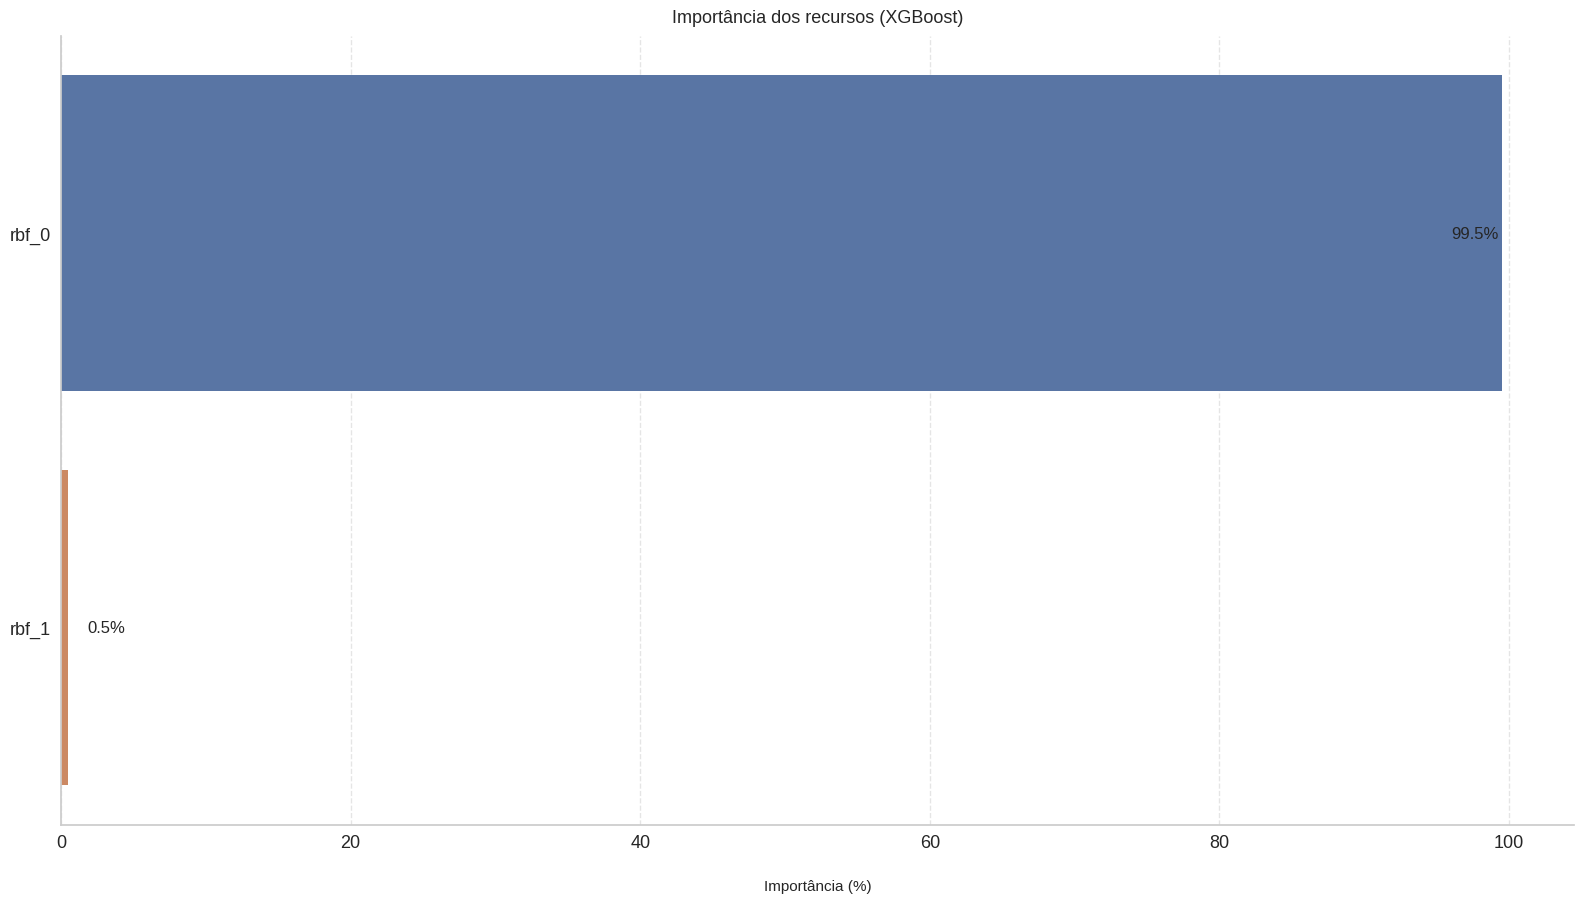

In [95]:
# Importancia das variaveis (Feature Importance) do modelo XGBoost

plot_feature_importances(best_features_importance, model="XGBoost")


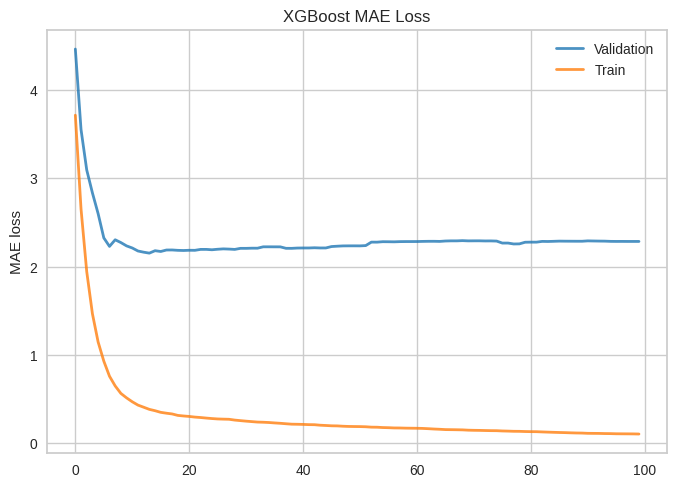

In [96]:
results = xgb_model.evals_result()
train_mae, val_mae = results["validation_0"]["mae"], results["validation_1"]["mae"]
epochs = len(train_mae)
x_axis = range(0, epochs)
plt.plot(x_axis, val_mae, label="Validation", color=color_test, lw=2, alpha=0.8)
plt.plot(x_axis, train_mae, label="Train", color=color_forecast, lw=2, alpha=0.8)
plt.legend()
plt.ylabel("MAE loss")
plt.title("XGBoost MAE Loss")
plt.show()


-----
#### LGBM Regressor

In [97]:
lgb_model = lgb.LGBMRegressor(metric="mae", n_jobs=-1, verbose=-1)

performance_models = []
all_feature_importances = []
all_predictions = []

start_time = time.time()
for i in tqdm(range(len(X_train)), desc="Training Progress"):
    lgb_model.fit(
        X_train[i],
        y_train,
        eval_set=[(X_train[i], y_train), (X_test[i], y_test)],
    )

    y_pred= lgb_model.predict(X_test[i])
    all_predictions.append(y_pred)

    fi_df = pd.DataFrame(
        data=lgb_model.feature_importances_,
        index=lgb_model.feature_name_,
        columns=["importance"],
    )
    all_feature_importances.append(fi_df)
    
    predictions_accuracy = calculate_forecast_accuracy(df_test[TARGET], y_pred, y_train[TARGET])
    performance_models.append(predictions_accuracy)

idx_best = np.argmin([metric["mae"] for metric in performance_models])
df_pred["lgb_pred"] = all_predictions[idx_best]

feature_importances_ = pd.concat(all_feature_importances, axis="columns")
feature_importances_.columns = feature_sets.keys()
performance_models_ = pd.DataFrame(performance_models, index=feature_sets.keys())
best_features_importance = all_feature_importances[idx_best].sort_values(by="importance", ascending=False)

best_feature_set_key = list(feature_sets.keys())[idx_best]
print_forecast_accuracy(df_pred["test"], df_pred["lgb_pred"], y_train[TARGET], f"{lgb_model.__module__} - {best_feature_set_key}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Training Progress: 100%|██████████| 15/15 [00:01<00:00,  9.25it/s]


                      Resumo das métricas de precisão (forecast accuracy - lightgbm.sklearn - TCR)                      

MAE :     1.36 - As previsões, em média, estão 1.36 unidades distantes dos valores reais.
RMSE:     2.26 - O erro médio do seu modelo é de 2.26 unidades em relação aos valores observados.
R²  :     0.92 - O coeficiente de determinação R² é 0.92.
MSE :     5.09 - A média dos quadrados das diferenças entre os valores previstos e reais é 5.09
MAPE:  221.84% - As previsões, em média, estão desviando em 221.84% dos valores reais.
MASE:    1.02 - O erro médio do seu modelo é 1.02 vezes maior que o erro médio do modelo Naive Lag.

Total training time: 1.64 seconds


In [98]:
feature_importances_.sort_values(by=best_feature_set_key, ascending=False, inplace=True)
performance_models_.sort_values(by="mae", ascending=True, inplace=True)
column_order = performance_models_.T.columns

#display(df_pred.head(5).style.format("{:.4f}"))
print("Performance Models:")
display(performance_models_.T.head(7).style.format("{:.2f}"))
print("Feature Importance:")
display(feature_importances_[column_order].head(7).style.format("{:.3f}"))


Performance Models:


Feature Importance:


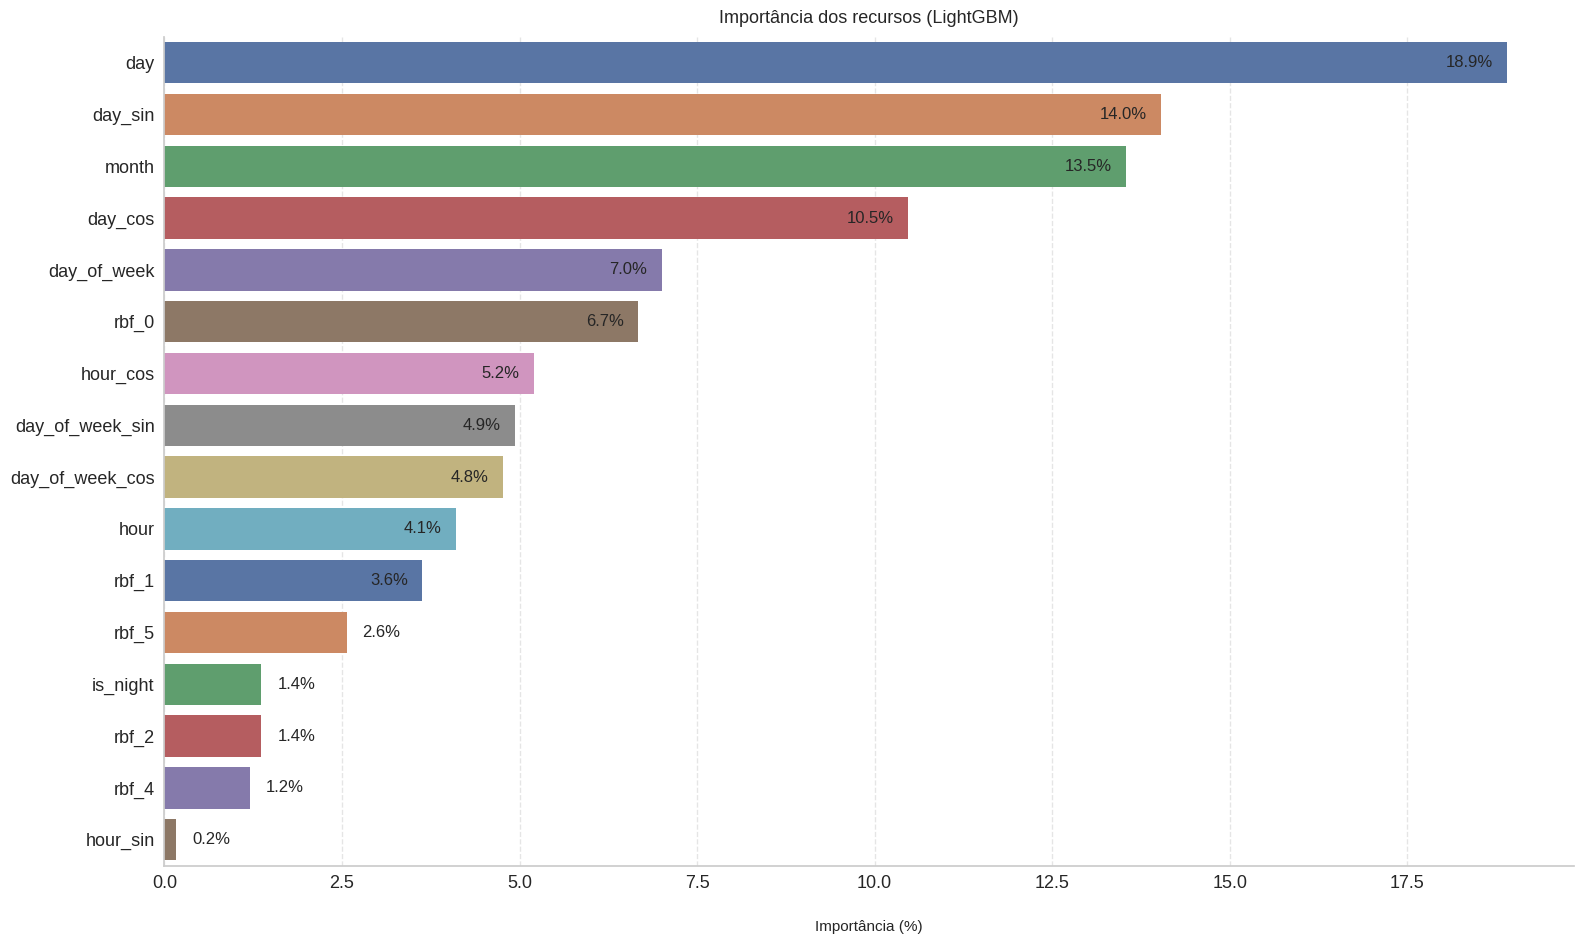

In [99]:
# Importancia das Variaveis (Feature Importance) LightGBM

plot_feature_importances(best_features_importance, model="LightGBM")


--------
#### Random Forest Regressor

In [100]:
rfr_model = RandomForestRegressor()

performance_models = []
all_feature_importances = []
all_predictions = []

start_time = time.time()
for i in tqdm(range(len(X_train)), desc="Training Progress"):
    rfr_model.fit(X_train[i], y_train.values.ravel())

    y_pred= rfr_model.predict(X_test[i])
    all_predictions.append(y_pred)

    fi_df = pd.DataFrame(
        data=rfr_model.feature_importances_,
        index=rfr_model.feature_names_in_,
        columns=["importance"],
    )
    all_feature_importances.append(fi_df)
    
    predictions_accuracy = calculate_forecast_accuracy(df_test[TARGET], y_pred, y_train[TARGET])
    performance_models.append(predictions_accuracy)

idx_best = np.argmin([metric["mae"] for metric in performance_models])
df_pred["rfr_pred"] = all_predictions[idx_best]

feature_importances_ = pd.concat(all_feature_importances, axis="columns")
feature_importances_.columns = feature_sets.keys()
performance_models_ = pd.DataFrame(performance_models, index=feature_sets.keys())
best_features_importance = all_feature_importances[idx_best].sort_values(by="importance", ascending=False)

best_feature_set_key = list(feature_sets.keys())[idx_best]
print_forecast_accuracy(df_pred["test"], df_pred["rfr_pred"], y_train[TARGET], f"{rfr_model.__module__} - {best_feature_set_key}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Training Progress: 100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


                  Resumo das métricas de precisão (forecast accuracy - sklearn.ensemble._forest - TC)                   

MAE :     1.22 - As previsões, em média, estão 1.22 unidades distantes dos valores reais.
RMSE:     2.20 - O erro médio do seu modelo é de 2.20 unidades em relação aos valores observados.
R²  :     0.92 - O coeficiente de determinação R² é 0.92.
MSE :     4.84 - A média dos quadrados das diferenças entre os valores previstos e reais é 4.84
MAPE:   84.81% - As previsões, em média, estão desviando em 84.81% dos valores reais.
MASE:    0.91 - O erro médio do seu modelo é 0.91 vezes maior que o erro médio do modelo Naive Lag.

Total training time: 10.11 seconds


In [101]:
feature_importances_.sort_values(by=best_feature_set_key, ascending=False, inplace=True)
performance_models_.sort_values(by="mae", ascending=True, inplace=True)
column_order = performance_models_.T.columns

#display(df_pred.head(5).style.format("{:.4f}"))
print("Performance Models:")
display(performance_models_.T.head(7).style.format("{:.2f}"))
print("Feature Importance:")
display(feature_importances_[column_order].head(7).style.format("{:.3f}"))


Performance Models:


Feature Importance:


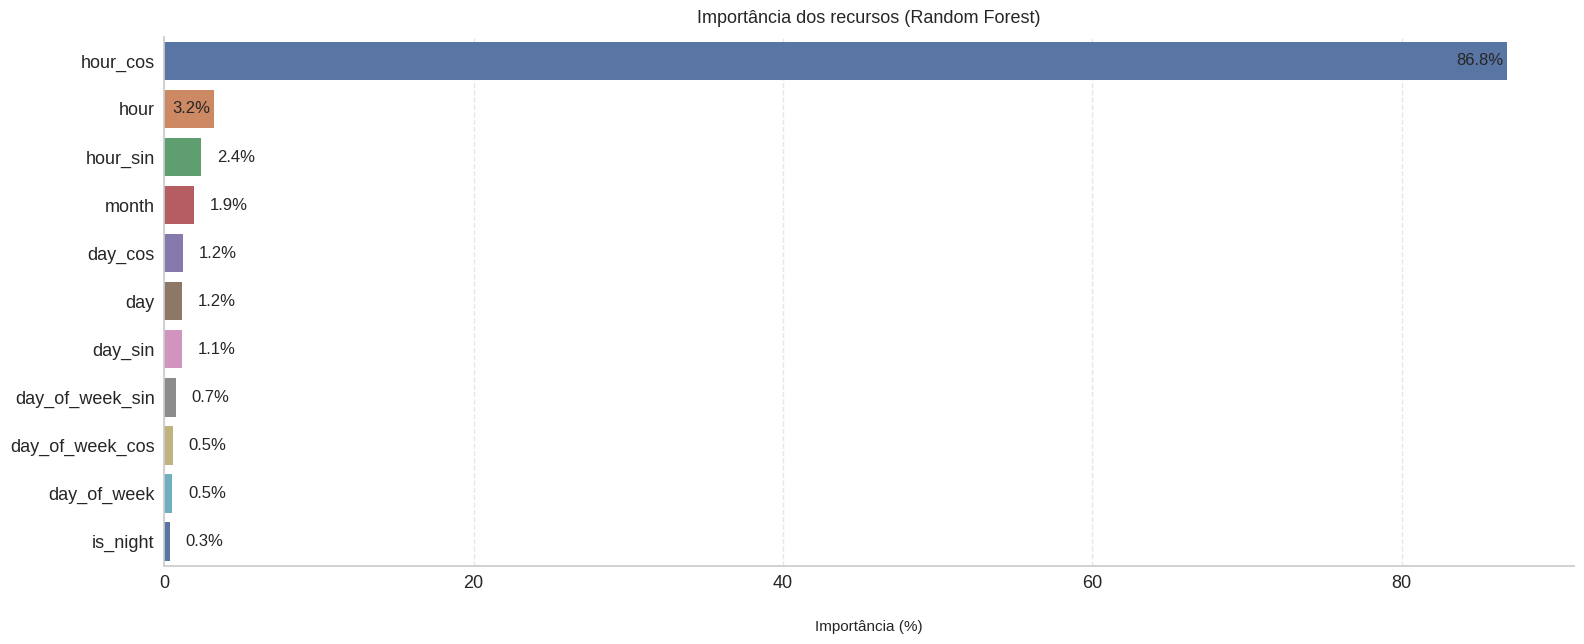

In [102]:
# Importancia das Variaveis (Feature Importance) Random Forest

plot_feature_importances(best_features_importance, model="Random Forest")


--------
#### LinearRegression

In [103]:
lr_model = LinearRegression()

performance_models = []
all_feature_importances = []
all_predictions = []

start_time = time.time()
for i in tqdm(range(len(X_train)), desc="Training Progress"):
    lr_model.fit(X_train[i], y_train.values.ravel())

    y_pred= lr_model.predict(X_test[i])
    all_predictions.append(y_pred)

    fi_df = pd.DataFrame(
        data=np.abs(lr_model.coef_),
        index=X_train[i].columns,
        columns=["importance"],
    )

    all_feature_importances.append(fi_df)
    
    predictions_accuracy = calculate_forecast_accuracy(df_test[TARGET], y_pred, y_train[TARGET])
    performance_models.append(predictions_accuracy)

idx_best = np.argmin([metric["mae"] for metric in performance_models])
df_pred["lr_pred"] = all_predictions[idx_best]

feature_importances_ = pd.concat(all_feature_importances, axis="columns")
feature_importances_.columns = feature_sets.keys()
performance_models_ = pd.DataFrame(performance_models, index=feature_sets.keys())
best_features_importance = all_feature_importances[idx_best].sort_values(by="importance", ascending=False)

best_feature_set_key = list(feature_sets.keys())[idx_best]
print_forecast_accuracy(df_pred["test"], df_pred["lr_pred"], y_train[TARGET], f"{lr_model.__module__} - {best_feature_set_key}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Training Progress: 100%|██████████| 15/15 [00:00<00:00, 70.34it/s]


                 Resumo das métricas de precisão (forecast accuracy - sklearn.linear_model._base - RF)                  

MAE :     1.48 - As previsões, em média, estão 1.48 unidades distantes dos valores reais.
RMSE:     2.45 - O erro médio do seu modelo é de 2.45 unidades em relação aos valores observados.
R²  :     0.91 - O coeficiente de determinação R² é 0.91.
MSE :     6.01 - A média dos quadrados das diferenças entre os valores previstos e reais é 6.01
MAPE:  141.58% - As previsões, em média, estão desviando em 141.58% dos valores reais.
MASE:    1.11 - O erro médio do seu modelo é 1.11 vezes maior que o erro médio do modelo Naive Lag.

Total training time: 0.24 seconds


In [104]:
feature_importances_.sort_values(by=best_feature_set_key, ascending=False, inplace=True)
performance_models_.sort_values(by="mae", ascending=True, inplace=True)
column_order = performance_models_.T.columns

#display(df_pred.head(5).style.format("{:.4f}"))
print("Performance Models:")
display(performance_models_.T.head(7).style.format("{:.2f}"))
print("Feature Importance:")
display(feature_importances_[column_order].head(7).style.format("{:.3f}"))


Performance Models:


Feature Importance:


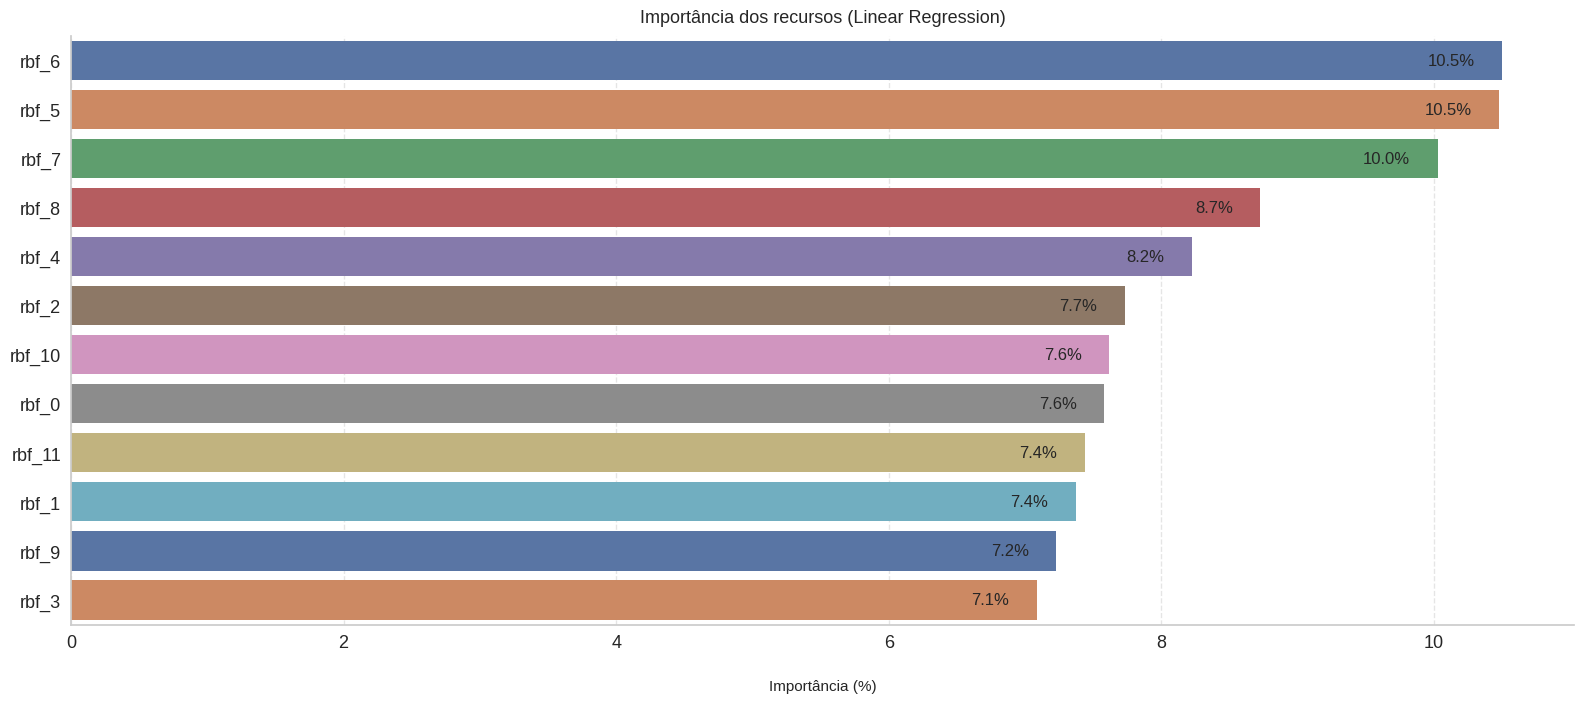

In [105]:
# Importancia das Variaveis (Feature Importance) Linear Regression

plot_feature_importances(best_features_importance, model="Linear Regression")


---
#### Lasso Regressor

In [106]:
ls_model = Lasso(alpha=1, random_state=0)

performance_models = []
all_feature_importances = []
all_predictions = []

start_time = time.time()
for i in tqdm(range(len(X_train)), desc="Training Progress"):
    ls_model.fit(X_train[i], y_train.values.ravel())

    y_pred= ls_model.predict(X_test[i])
    all_predictions.append(y_pred)

    fi_df = pd.DataFrame(
        data=np.abs(ls_model.coef_),
        index=X_train[i].columns,
        columns=["importance"],
    )

    all_feature_importances.append(fi_df)
    
    predictions_accuracy = calculate_forecast_accuracy(df_test[TARGET], y_pred, y_train[TARGET])
    performance_models.append(predictions_accuracy)

idx_best = np.argmin([metric["mae"] for metric in performance_models])
df_pred["ls_pred"] = all_predictions[idx_best]

feature_importances_ = pd.concat(all_feature_importances, axis="columns")
feature_importances_.columns = feature_sets.keys()
performance_models_ = pd.DataFrame(performance_models, index=feature_sets.keys())
best_features_importance = all_feature_importances[idx_best].sort_values(by="importance", ascending=False)

best_feature_set_key = list(feature_sets.keys())[idx_best]
print_forecast_accuracy(df_pred["test"], df_pred["ls_pred"], y_train[TARGET], f"{ls_model.__module__} - {best_feature_set_key}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Training Progress: 100%|██████████| 15/15 [00:00<00:00, 34.72it/s]


          Resumo das métricas de precisão (forecast accuracy - sklearn.linear_model._coordinate_descent - TC)           

MAE :     3.66 - As previsões, em média, estão 3.66 unidades distantes dos valores reais.
RMSE:     4.85 - O erro médio do seu modelo é de 4.85 unidades em relação aos valores observados.
R²  :     0.63 - O coeficiente de determinação R² é 0.63.
MSE :    23.55 - A média dos quadrados das diferenças entre os valores previstos e reais é 23.55
MAPE: 2856.62% - As previsões, em média, estão desviando em 2856.62% dos valores reais.
MASE:    2.74 - O erro médio do seu modelo é 2.74 vezes maior que o erro médio do modelo Naive Lag.

Total training time: 0.45 seconds


In [107]:
feature_importances_.sort_values(by=best_feature_set_key, ascending=False, inplace=True)
performance_models_.sort_values(by="mae", ascending=True, inplace=True)
column_order = performance_models_.T.columns

#display(df_pred.head(5).style.format("{:.4f}"))
print("Performance Models:")
display(performance_models_.T.head(7).style.format("{:.2f}"))
print("Feature Importance:")
display(feature_importances_[column_order].head(7).style.format("{:.3f}"))


Performance Models:


Feature Importance:


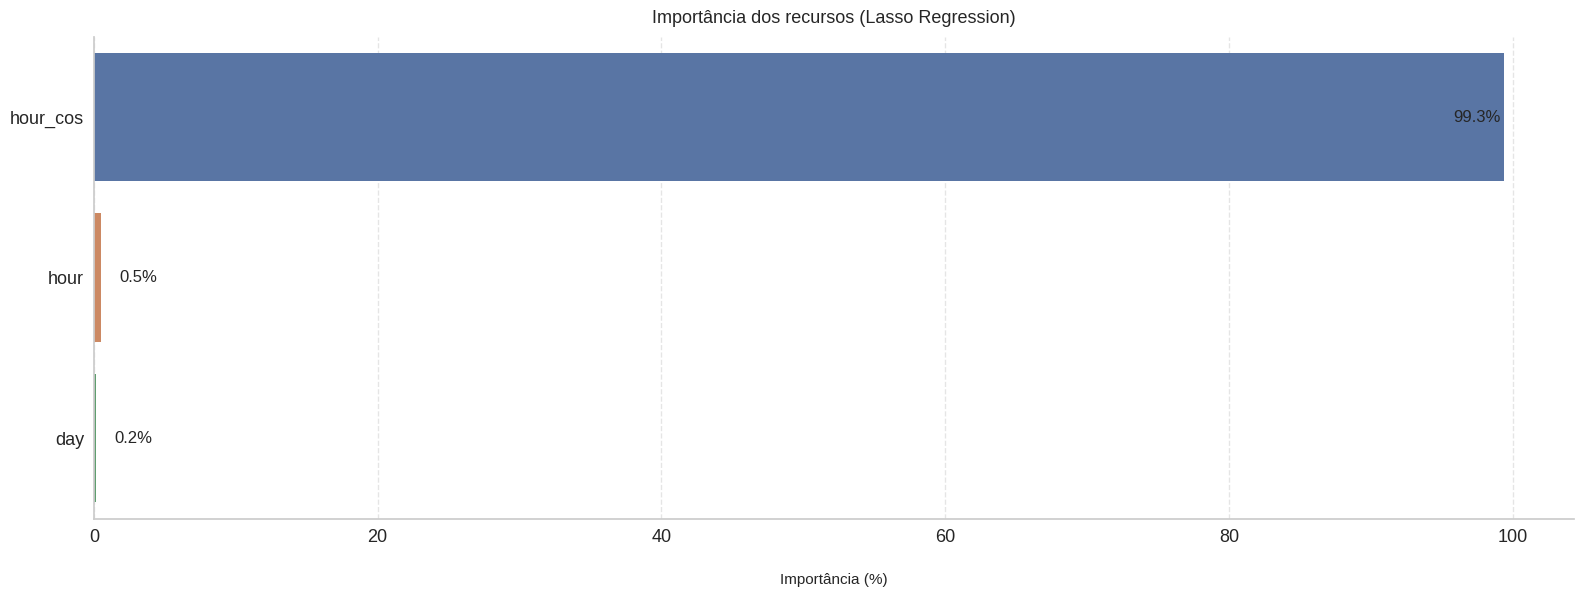

In [108]:
# Importancia das Variaveis (Feature Importance) Linear Regression

plot_feature_importances(best_features_importance, model="Lasso Regression")


---
#### Decision Tree Regressor

In [109]:
dtr_model = DecisionTreeRegressor()

performance_models = []
all_feature_importances = []
all_predictions = []

start_time = time.time()
for i in tqdm(range(len(X_train)), desc="Training Progress"):
    dtr_model.fit(X_train[i], y_train.values.ravel())

    y_pred= dtr_model.predict(X_test[i])
    all_predictions.append(y_pred)

    fi_df = pd.DataFrame(
        data=dtr_model.feature_importances_,
        index=dtr_model.feature_names_in_,
        columns=["importance"],
    )

    all_feature_importances.append(fi_df)
    
    predictions_accuracy = calculate_forecast_accuracy(df_test[TARGET], y_pred, y_train[TARGET])
    performance_models.append(predictions_accuracy)

idx_best = np.argmin([metric["mae"] for metric in performance_models])
df_pred["dtr_pred"] = all_predictions[idx_best]

feature_importances_ = pd.concat(all_feature_importances, axis="columns")
feature_importances_.columns = feature_sets.keys()
performance_models_ = pd.DataFrame(performance_models, index=feature_sets.keys())
best_features_importance = all_feature_importances[idx_best].sort_values(by="importance", ascending=False)

best_feature_set_key = list(feature_sets.keys())[idx_best]
print_forecast_accuracy(df_pred["test"], df_pred["dtr_pred"], y_train[TARGET], f"{lr_model.__module__} - {best_feature_set_key}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")



Training Progress: 100%|██████████| 15/15 [00:00<00:00, 54.68it/s]


                 Resumo das métricas de precisão (forecast accuracy - sklearn.linear_model._base - TC)                  

MAE :     1.37 - As previsões, em média, estão 1.37 unidades distantes dos valores reais.
RMSE:     2.59 - O erro médio do seu modelo é de 2.59 unidades em relação aos valores observados.
R²  :     0.90 - O coeficiente de determinação R² é 0.90.
MSE :     6.72 - A média dos quadrados das diferenças entre os valores previstos e reais é 6.72
MAPE:   83.08% - As previsões, em média, estão desviando em 83.08% dos valores reais.
MASE:    1.03 - O erro médio do seu modelo é 1.03 vezes maior que o erro médio do modelo Naive Lag.

Total training time: 0.29 seconds


In [110]:
feature_importances_.sort_values(by=best_feature_set_key, ascending=False, inplace=True)
performance_models_.sort_values(by="mae", ascending=True, inplace=True)
column_order = performance_models_.T.columns

#display(df_pred.head(5).style.format("{:.4f}"))
print("Performance Models:")
display(performance_models_.T.head(7).style.format("{:.2f}"))
print("Feature Importance:")
display(feature_importances_[column_order].head(7).style.format("{:.3f}"))


Performance Models:


Feature Importance:


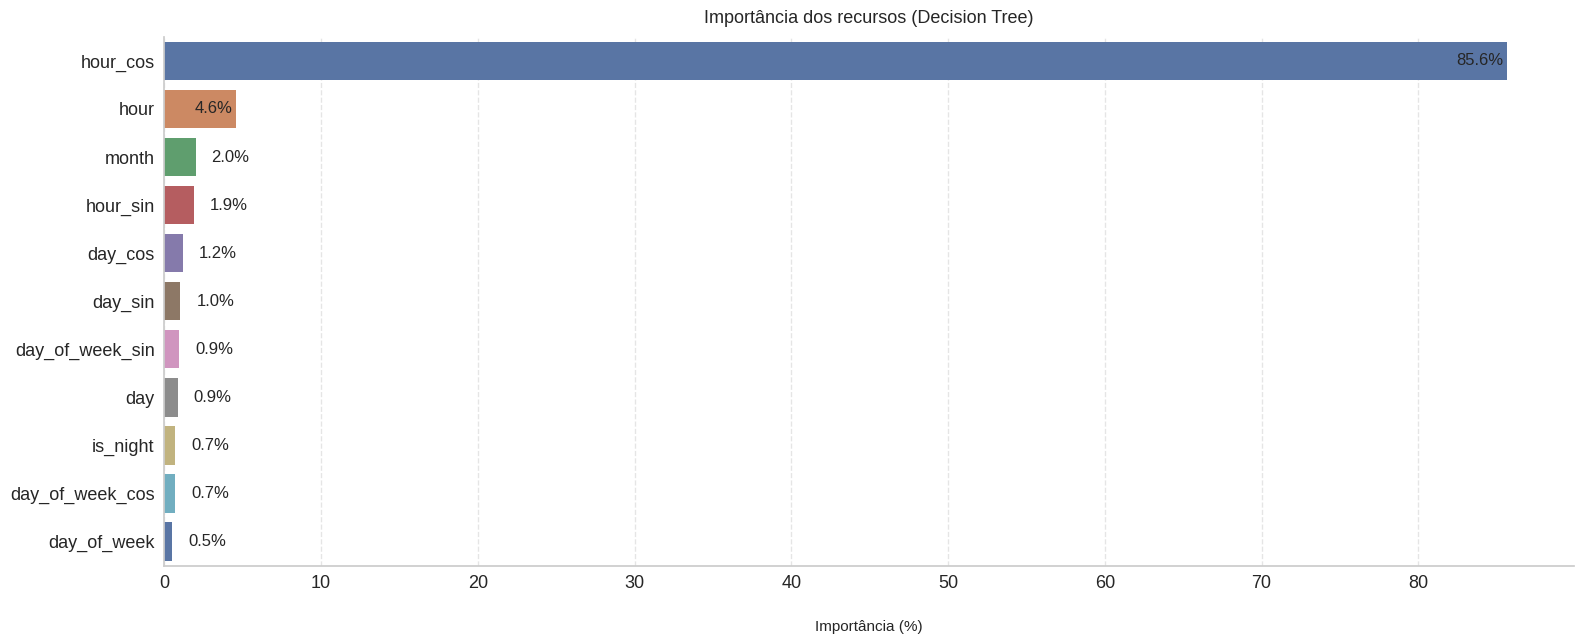

In [111]:
# Importancia das Variaveis (Feature Importance) Decision Tree

plot_feature_importances(best_features_importance, model="Decision Tree")


-----
#### Gradient Boosting Regressor

In [112]:
gbr_model = GradientBoostingRegressor()

performance_models = []
all_feature_importances = []
all_predictions = []

start_time = time.time()
for i in tqdm(range(len(X_train)), desc="Training Progress"):

    gbr_model.fit(
        X_train[i],
        y_train.values.ravel(),
    )
    
    y_pred= gbr_model.predict(X_test[i])
    all_predictions.append(y_pred)

    # fi_df = pd.DataFrame(
    #     data=xgb_model.feature_importances_,
    #     index=xgb_model.feature_names_in_,
    #     columns=["importance"],
    # )
    # all_feature_importances.append(fi_df)
    
    predictions_accuracy = calculate_forecast_accuracy(df_test[TARGET], y_pred, y_train[TARGET])
    performance_models.append(predictions_accuracy)

idx_best = np.argmin([metric["mae"] for metric in performance_models])
df_pred["gbr_pred"] = all_predictions[idx_best]

# feature_importances_ = pd.concat(all_feature_importances, axis="columns")
# feature_importances_.columns = feature_sets.keys()
performance_models_ = pd.DataFrame(performance_models, index=feature_sets.keys())
# best_features_importance = all_feature_importances[idx_best].sort_values(by="importance", ascending=False)

best_feature_set_key = list(feature_sets.keys())[idx_best]
print_forecast_accuracy(df_pred["test"], df_pred["gbr_pred"], y_train[TARGET], f"{gbr_model.__module__} - {best_feature_set_key}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Training Progress: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]


                    Resumo das métricas de precisão (forecast accuracy - sklearn.ensemble._gb - TCR)                    

MAE :     1.27 - As previsões, em média, estão 1.27 unidades distantes dos valores reais.
RMSE:     2.20 - O erro médio do seu modelo é de 2.20 unidades em relação aos valores observados.
R²  :     0.92 - O coeficiente de determinação R² é 0.92.
MSE :     4.83 - A média dos quadrados das diferenças entre os valores previstos e reais é 4.83
MAPE:  231.25% - As previsões, em média, estão desviando em 231.25% dos valores reais.
MASE:    0.95 - O erro médio do seu modelo é 0.95 vezes maior que o erro médio do modelo Naive Lag.

Total training time: 4.36 seconds


In [113]:
# feature_importances_.sort_values(by=best_feature_set_key, ascending=False, inplace=True)
performance_models_.sort_values(by="mae", ascending=True, inplace=True)
column_order = performance_models_.T.columns

#display(df_pred.head(5).style.format("{:.4f}"))
print("Performance Models:")
display(performance_models_.T.head(10).style.format("{:.3f}"))
print("Feature Importance:")
# display(feature_importances_[column_order].head(10).style.format("{:.4f}"))


Performance Models:


Feature Importance:


-----
#### Extra Trees Regressor

In [114]:
etr_model = ExtraTreesRegressor()

performance_models = []
all_feature_importances = []
all_predictions = []

start_time = time.time()
for i in tqdm(range(len(X_train)), desc="Training Progress"):

    etr_model.fit(
        X_train[i],
        y_train.values.ravel(),
    )
    
    y_pred= etr_model.predict(X_test[i])
    all_predictions.append(y_pred)

    # fi_df = pd.DataFrame(
    #     data=xgb_model.feature_importances_,
    #     index=xgb_model.feature_names_in_,
    #     columns=["importance"],
    # )
    # all_feature_importances.append(fi_df)
    
    predictions_accuracy = calculate_forecast_accuracy(df_test[TARGET], y_pred, y_train[TARGET])
    performance_models.append(predictions_accuracy)

idx_best = np.argmin([metric["mae"] for metric in performance_models])
df_pred["etr_pred"] = all_predictions[idx_best]

# feature_importances_ = pd.concat(all_feature_importances, axis="columns")
# feature_importances_.columns = feature_sets.keys()
performance_models_ = pd.DataFrame(performance_models, index=feature_sets.keys())
# best_features_importance = all_feature_importances[idx_best].sort_values(by="importance", ascending=False)

best_feature_set_key = list(feature_sets.keys())[idx_best]
print_forecast_accuracy(df_pred["test"], df_pred["etr_pred"], y_train[TARGET], f"{etr_model.__module__} - {best_feature_set_key}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Training Progress: 100%|██████████| 15/15 [00:06<00:00,  2.37it/s]


                  Resumo das métricas de precisão (forecast accuracy - sklearn.ensemble._forest - TF)                   

MAE :     1.33 - As previsões, em média, estão 1.33 unidades distantes dos valores reais.
RMSE:     2.42 - O erro médio do seu modelo é de 2.42 unidades em relação aos valores observados.
R²  :     0.91 - O coeficiente de determinação R² é 0.91.
MSE :     5.86 - A média dos quadrados das diferenças entre os valores previstos e reais é 5.86
MAPE:   81.47% - As previsões, em média, estão desviando em 81.47% dos valores reais.
MASE:    1.00 - O erro médio do seu modelo é 1.00 vezes maior que o erro médio do modelo Naive Lag.

Total training time: 6.35 seconds


In [115]:
# feature_importances_.sort_values(by=best_feature_set_key, ascending=False, inplace=True)
performance_models_.sort_values(by="mae", ascending=True, inplace=True)
column_order = performance_models_.T.columns

#display(df_pred.head(5).style.format("{:.4f}"))
print("Performance Models:")
display(performance_models_.T.head(10).style.format("{:.3f}"))
print("Feature Importance:")
# display(feature_importances_[column_order].head(10).style.format("{:.4f}"))


Performance Models:


Feature Importance:


-----
#### Hist Gradient Boosting Regressor

In [116]:
hgbr_model = HistGradientBoostingRegressor()


performance_models = []
all_feature_importances = []
all_predictions = []

start_time = time.time()
for i in tqdm(range(len(X_train)), desc="Training Progress"):

    hgbr_model.fit(
        X_train[i],
        y_train.values.ravel(),
    )
    
    y_pred= hgbr_model.predict(X_test[i])
    all_predictions.append(y_pred)

    # fi_df = pd.DataFrame(
    #     data=xgb_model.feature_importances_,
    #     index=xgb_model.feature_names_in_,
    #     columns=["importance"],
    # )
    # all_feature_importances.append(fi_df)
    
    predictions_accuracy = calculate_forecast_accuracy(df_test[TARGET], y_pred, y_train[TARGET])
    performance_models.append(predictions_accuracy)

idx_best = np.argmin([metric["mae"] for metric in performance_models])
df_pred["hgbr_pred"] = all_predictions[idx_best]

# feature_importances_ = pd.concat(all_feature_importances, axis="columns")
# feature_importances_.columns = feature_sets.keys()
performance_models_ = pd.DataFrame(performance_models, index=feature_sets.keys())
# best_features_importance = all_feature_importances[idx_best].sort_values(by="importance", ascending=False)

best_feature_set_key = list(feature_sets.keys())[idx_best]
print_forecast_accuracy(df_pred["test"], df_pred["hgbr_pred"], y_train[TARGET], f"{hgbr_model.__module__} - {best_feature_set_key}")

end_time = time.time()
total_time = end_time - start_time
print(f"Total training time: {total_time:.2f} seconds")


Training Progress: 100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


 Resumo das métricas de precisão (forecast accuracy - sklearn.ensemble._hist_gradient_boosting.gradient_boosting - TCR) 

MAE :     1.32 - As previsões, em média, estão 1.32 unidades distantes dos valores reais.
RMSE:     2.25 - O erro médio do seu modelo é de 2.25 unidades em relação aos valores observados.
R²  :     0.92 - O coeficiente de determinação R² é 0.92.
MSE :     5.06 - A média dos quadrados das diferenças entre os valores previstos e reais é 5.06
MAPE:  149.86% - As previsões, em média, estão desviando em 149.86% dos valores reais.
MASE:    0.99 - O erro médio do seu modelo é 0.99 vezes maior que o erro médio do modelo Naive Lag.

Total training time: 12.11 seconds


In [117]:
# feature_importances_.sort_values(by=best_feature_set_key, ascending=False, inplace=True)
performance_models_.sort_values(by="mae", ascending=True, inplace=True)
column_order = performance_models_.T.columns

#display(df_pred.head(5).style.format("{:.4f}"))
print("Performance Models:")
display(performance_models_.T.head(10).style.format("{:.3f}"))
print("Feature Importance:")
# display(feature_importances_[column_order].head(10).style.format("{:.4f}"))


Performance Models:


Feature Importance:


---
### Desempenho dos modelos (Forecast Accuracy)

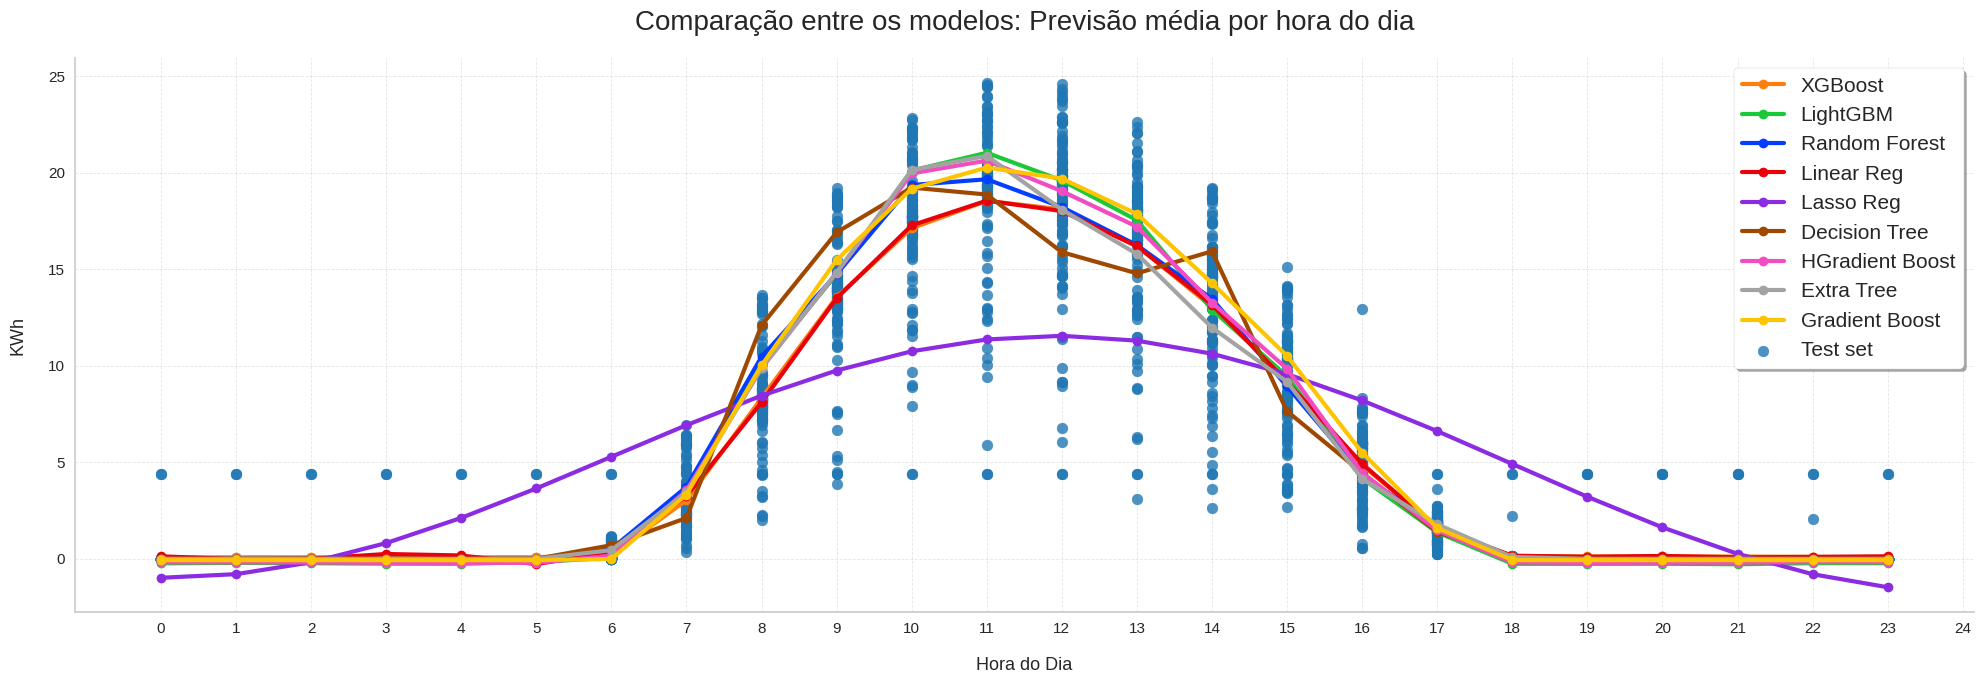

In [118]:
mean_pred = df_pred.groupby(df_pred.index.hour).mean()
colors = sns.color_palette("bright")

plt.figure(figsize=(20, 7))

predictions = [
    ("XGBoost", "xgb_pred", color_forecast, 3),
    ("LightGBM", "lgb_pred", colors[2], 3),
    ("Random Forest", "rfr_pred", colors[0], 3),
    ("Linear Reg", "lr_pred", colors[3], 3),
    ("Lasso Reg", "ls_pred", colors[4], 3),
    ("Decision Tree", "dtr_pred", colors[5], 3),
    ("HGradient Boost", "hgbr_pred", colors[6], 3),
    ("Extra Tree", "etr_pred", colors[7], 3),
    ("Gradient Boost", "gbr_pred", colors[8], 3),
]

for label, pred_col, color, lw in predictions:
    plt.plot(
        mean_pred.index,
        mean_pred[pred_col],
        label=label,
        color=color,
        lw=lw,
        marker="o",
    )

plt.scatter(
    df_base["hour"],
    df_base["ldtea"],
    label="Test set",
    color=color_test,
    s=60,
    alpha=0.8,
)

plt.title("Comparação entre os modelos: Previsão média por hora do dia", fontsize=20, pad=20)
plt.xlabel("Hora do Dia", fontsize=13, labelpad=15)
plt.ylabel("KWh", fontsize=13, labelpad=15)
plt.grid(True, linestyle="--", alpha=0.5, lw=0.6)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.xticks(np.arange(0, 25))
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
)
plt.tight_layout()
plt.show()


In [121]:
df_score = pd.DataFrame()

df_score["XGBoost"] = calculate_forecast_accuracy(df_pred["test"], df_pred["xgb_pred"], y_train[TARGET])
df_score["LightGBM"] = calculate_forecast_accuracy(df_pred["test"], df_pred["lgb_pred"], y_train[TARGET])
df_score["Random Forest"] = calculate_forecast_accuracy(df_pred["test"], df_pred["rfr_pred"], y_train[TARGET])
df_score["Linear Regression"] = calculate_forecast_accuracy(df_pred["test"], df_pred["lr_pred"], y_train[TARGET])
df_score["Lasso Regression"] = calculate_forecast_accuracy(df_pred["test"], df_pred["ls_pred"], y_train[TARGET])
df_score["Decision Tree"] = calculate_forecast_accuracy(df_pred["test"], df_pred["dtr_pred"], y_train[TARGET])
df_score["HGradient Boost"] = calculate_forecast_accuracy(df_pred["test"], df_pred["hgbr_pred"], y_train[TARGET])
df_score["Extra Tree"] = calculate_forecast_accuracy(df_pred["test"], df_pred["etr_pred"], y_train[TARGET])
df_score["Gradient Boost"] = calculate_forecast_accuracy(df_pred["test"], df_pred["gbr_pred"], y_train[TARGET])

df_score = df_score.T
df_score = df_score.round(2)
df_score.sort_values(by=["mae", "mse", "rmse"], inplace=True)
# df_score = df_score.iloc[:-1]  # remover o pior modelo
df_score.head(10)




mae  rmse    mse    r2     mape   smape  mase
Random Forest      1.22  2.20   4.84  0.92    84.81   50.90  0.91
Gradient Boost     1.27  2.20   4.83  0.92   231.25  119.39  0.95
HGradient Boost    1.32  2.25   5.06  0.92   149.86  118.45  0.99
Extra Tree         1.33  2.42   5.86  0.91    81.47   58.32  1.00
LightGBM           1.36  2.26   5.09  0.92   221.84  119.85  1.02
Decision Tree      1.37  2.59   6.72  0.90    83.08   39.29  1.03
XGBoost            1.47  2.46   6.04  0.91   121.14  114.78  1.10
Linear Regression  1.48  2.45   6.01  0.91   141.58  113.69  1.11
Lasso Regression   3.66  4.85  23.55  0.63  2856.62  130.47  2.74

In [ ]:
df_plot = (
    df_score[["mae", "mse", "rmse", "r2"]]
    .reset_index()
    .melt(
        id_vars="index",
        var_name="metric",
        value_name="value",
    )
)
df_plot["metric"] = df_plot["metric"].str.upper()

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data=df_plot,
    x="index",
    y="value",
    hue="metric",
    width=0.8,
    palette="Paired",
    saturation=0.9,
    dodge=True, 
)

ax.set_title("Comparação de métricas de desempenho dos modelos", fontsize=16)
ax.set_xlabel("")
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.7)
ax.spines["bottom"].set_linewidth(0.7)
ax.yaxis.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

plt.xticks(rotation=0, ha="center", fontsize=10)
plt.yticks(fontsize=10)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=10,
        color="black",
    )

ax.annotate(
    "(R²) maior melhor",
    (1.05, 0.6),
    xycoords="axes fraction",
    ha="center",
    va="bottom",
    fontsize=12,
    color="black",
    alpha=0.8,
)


plt.legend(
    loc="upper left",
    fontsize=12,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
plt.show()


In [ ]:
df_plot = (
    df_score[["mae", "mse", "rmse", "r2"]]
    .reset_index()
    .melt(
        id_vars="index",
        var_name="metric",
        value_name="value",
    )
)
df_plot["metric"] = df_plot["metric"].str.upper()

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(
    data=df_plot,
    x="metric",
    y="value",
    hue="index",
    width=0.8,
    palette="Paired",
    saturation=0.9,
    dodge=True, 
)

ax.set_title("Comparação de métricas de desempenho dos modelos", fontsize=16, pad=25)
ax.set_xlabel("")
ax.set_ylabel("")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_linewidth(0.7)
ax.spines["bottom"].set_linewidth(0.7)
ax.yaxis.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

plt.xticks(rotation=0, ha="center", fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="bottom",
        fontsize=11,
        color="black",
    )

plt.legend(
    loc="upper left",
    fontsize=11,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
)
plt.tight_layout()
plt.show()


In [ ]:
df_plot = (
    df_score[["mae", "mse", "rmse", "r2"]]
    .reset_index()
    .melt(
        id_vars="index",
        var_name="metric",
        value_name="value",
    )
)

colors = sns.color_palette("Paired")

fig, axes = plt.subplots(2, 2, figsize=(15, 8))

metrics = df_plot["metric"].unique()
for i, j in itertools.product(range(2), range(2)):
    metric = metrics[i * 2 + j]
    ax = axes[i, j]
    df_group = df_plot[df_plot["metric"] == metric].copy()
    df_group.sort_values("value", ascending=True, inplace=True)

    ax.bar(
        df_group["index"],
        df_group["value"],
        color=colors,
        alpha=0.9,
    )

    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.2f}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="bottom",
            fontsize=9,
            color="black",
        )

    ax.set_title(f"{mapping_metrics[metric]} ({metric.upper()})", fontsize=10, pad=10)
    ax.tick_params(axis="x", labelsize=9)
    ax.tick_params(axis="y", labelsize=9)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(0.7)
    ax.spines["bottom"].set_linewidth(0.7)
    ax.yaxis.grid(True, linestyle="--", linewidth=0.5, color="gray", alpha=0.5)

plt.tight_layout()
plt.show()


In [ ]:
# Plotar previsao de energia (LDTEA) no conjunto de teste

df_plot = pd.concat([df_train[TARGET], df_pred], axis="columns")
df_plot.rename(columns={TARGET: "train"}, inplace=True)

plot_forecast(df_plot[["test", "xgb_pred"]], "XGBoost")
plot_forecast(df_plot[["test", "lgb_pred"]], "LightGBM")
plot_forecast(df_plot[["test", "lr_pred"]], "Linear Regression")
plot_forecast(df_plot[["test", "ls_pred"]], "Lasso Regression")
plot_forecast(df_plot[["test", "rfr_pred"]], "Random Forest")
plot_forecast(df_plot[["test", "dtr_pred"]], "Decision Trees")


In [ ]:
# Plotar previsao de energia (LDTEA) no conjunto de teste

start = df_train.index.max() - pd.DateOffset(days=0)
end = start + pd.DateOffset(days=7)
plot_forecast(
    df_plot[["test", "xgb_pred", "lgb_pred", "dtr_pred"]],
    "Top Models",
    start,
    end,
)

start = df_train.index.max() - pd.DateOffset(days=0)
end = start + pd.DateOffset(days=1)
plot_forecast(
    df_plot[["test", "xgb_pred", "lgb_pred", "dtr_pred"]],
    "Top Models",
    start,
    end,
)


--------
#### Previsao do futuro usando LightGBM
Features TCR (TIME_FEATURES   + CYCLIC_FEATURES + RADIAL_FEATURES,)

---
 - Retreinar com todos os daods disponiveis (treino + validacao)
 - Para prever o futuro, precisamos de um dataframe vazio para intervalos de datas futuros.
 - Crie os lags features e time features para o novo data

In [ ]:
X_all = df_base[TIME_FEATURES + CYCLIC_FEATURES + RADIAL_FEATURES]
y_all = df_base[[TARGET]]

print(f"X_all: {X_all.index.min()} - {X_all.index.max()}")
display(X_all.head(3))
print(f"y_all : {y_all.index.min()} - {y_all.index.max()}")
display(y_all.head(3))


In [ ]:
lgb_model_full = lgb.LGBMRegressor(metric="mae", n_jobs=-1, verbose=-1)

lgb_model_full.fit(
    X_all,
    y_all,
    eval_set=[(X_all, y_all)],
)


In [ ]:
# Criar o dataframe com datas futuras (24 horas)

start_date = df_base.index.max() + pd.Timedelta("1 hour")

forecast_horizon = pd.date_range(start=start_date, periods=24, freq="H")
df_future = pd.DataFrame(index=forecast_horizon, )
df_future.index.name = DATE_COL
df_future[TARGET] = np.nan
df_future = create_features(df_future)

print(f"df_future: {df_future.index.min()} - {df_future.index.max()}")
print(f"shape: {df_future.shape}")
df_future.tail()


In [ ]:
X_future = df_future[TIME_FEATURES + CYCLIC_FEATURES + RADIAL_FEATURES]
y_eval = df_eval.loc[forecast_horizon, [TARGET]]

fc_pred = lgb_model_full.predict(X_future)
fc_pred = pd.DataFrame(fc_pred, index=X_future.index, columns=["y_pred"])
fc_pred["y_true"] = y_eval
print_forecast_accuracy(fc_pred["y_true"], fc_pred["y_pred"], y_all[TARGET], "Recursive LightGBM")


In [ ]:
plt.figure(figsize=(20, 6))

plt.plot(df_base.index, df_base[TARGET], label="Train set", color=color_train, lw=2)
plt.plot(fc_pred.index, fc_pred["y_pred"], label="Forecast", color=color_future, lw=2)

plt.title("LightGBM - Forecast 24 steps recursive ", fontsize=20, fontweight="bold", pad=20)
plt.ylabel("KWh", fontsize=16, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)

plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
plt.show()



In [ ]:
plt.figure(figsize=(22, 6))

plt.plot(
    fc_pred.index,
    fc_pred["y_true"],
    label="Evalute set",
    color=color_test,
    marker="o",
    lw=4,
    markersize=12,
    markerfacecolor=dark_blue,
    markeredgewidth=2,
    markeredgecolor="blue",
)

plt.plot(
    fc_pred.index,
    fc_pred["y_pred"],
    label="Forecast",
    color=color_forecast,
    marker="o",
    ls="--",
    lw=4,
    markersize=12,
    markerfacecolor=golden_rod,
    markeredgewidth=2,
    markeredgecolor=dark_cyan,
)

plt.title("LightGBM - Forecast 24 steps recursive ", fontsize=18, fontweight="bold", pad=20)
plt.ylabel("KWh", fontsize=16, labelpad=15)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.grid(axis="y", alpha=0.4, linewidth=.9)
plt.grid(axis="x", alpha=0.4, linewidth=.9)

hours = mdatesDateFormatter.HourLocator(interval=1)
h_fmt = mdatesDateFormatter.DateFormatter("%H:%M")
plt.gca().xaxis.set_major_locator(hours)
plt.gca().xaxis.set_major_formatter(h_fmt)

plt.legend(
    fontsize=17,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
)
plt.tight_layout()
plt.show()


In [ ]:
# salvar modelo treinado com conjunto completo de dados

save_model(model=lgb_model_full, name="lgbm_tf", mode="pkl")


In [ ]:
# Carregar modelo treinado com conjunto completo de dados

model_loaded = load_model(name="lgbm_tf", mode="pkl")


In [ ]:
X_test = df_eval[TIME_FEATURES + CYCLIC_FEATURES + RADIAL_FEATURES]

y_pred = model_loaded.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=X_test.index, columns=["y_pred"])
y_pred["y_true"] = df_eval[TARGET]
y_pred["error"] = y_pred["y_true"] - y_pred["y_pred"]
y_pred["mae"] = np.abs(y_pred["error"])
y_pred.head()


In [ ]:
print_forecast_accuracy(y_pred["y_true"], y_pred["y_pred"], y_all[TARGET], "Forecast LGBM")


In [ ]:
# Plotar mean_absolute_error

idx_max = y_pred["mae"].idxmax()
idx_min = y_pred["mae"].idxmin()
point_max = y_pred.loc[idx_max]
point_min = y_pred.loc[idx_min]

avg_mae = y_pred["mae"].mean()

plt.figure(figsize=(22, 5))
plt.plot(y_pred.index, y_pred["mae"], lw=3, color=color_train, label="MAE")

plt.scatter(point_max.name, point_max["mae"], s=120, color="red", label="Max")
plt.axhline(avg_mae, lw=3, color=dark_golden_rod, ls="--", label="Avg")

plt.text(
    point_max.name,
    point_max["mae"] + 0.5,
    f"{point_max['mae']:.2f}",
    ha="left",
    va="bottom",
    fontsize=13,
    color="red",
)

plt.text(
    y_pred.index.min(),
    6,
    f"avg mae: {avg_mae:.2f}",
    ha="left",
    va="bottom",
    fontsize=16,
    color=dark_golden_rod,
    bbox=dict(boxstyle="round", pad=0.5, facecolor="white", alpha=0.5),
)

plt.title("Mean Absolute Error (MAE) - LightGBM", fontsize=18, pad=20)
plt.xlabel("")
plt.ylabel("KWh", fontsize=14, labelpad=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(
    fontsize=16,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(0.1, 1),
)
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(22, 5))
plt.plot(y_pred.index, y_pred["y_true"], lw=3, color=color_test, label="Real")
plt.plot(y_pred.index, y_pred["y_pred"], lw=3, ls="--", color=color_forecast, label="Forecast")

plt.title("Previsão de energia (LDTEA) - LightGBM", fontsize=18, pad=20)
plt.xlabel("")
plt.ylabel("KWh", fontsize=14, labelpad=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
plt.show()


In [ ]:
# plotar previsao e valor real para ao dia 5 de outubro:
df_filtred = y_pred.loc["2023-10-05 00:00:00":"2023-10-05 23:59:59"].copy()

idx = df_filtred["mae"].idxmax()
point = df_filtred.loc[idx]

plt.figure(figsize=(22, 5))
plt.plot(df_filtred.index, df_filtred["y_true"], lw=3, color=color_test, label="Real")
plt.plot(df_filtred.index, df_filtred["y_pred"], lw=3, ls="--", color=color_forecast, label="Forecast")
plt.scatter(point.name, point["y_true"], color=color_test, s=100)
plt.scatter(point.name, point["y_pred"], color=color_forecast, s=100)
plt.vlines(point.name, point["y_true"], point["y_pred"], color="red", lw=2, linestyle="--")
plt.text(
    point.name,
    point["y_true"] - 1.2,
    f"true: {point['y_true']:.2f}",
    ha="center",
    va="top",
    fontsize=14,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor=dark_blue, alpha=0.8),
)

plt.text(
    point.name,
    point["y_pred"] + 1,
    f"pred: {point['y_pred']:.2f}",
    ha="center",
    va="bottom",
    fontsize=14,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor=dark_orange, alpha=0.8),
)

plt.text(
    point.name + pd.DateOffset(minutes=10),
    (point["y_true"] + point["y_pred"]) / 2,
    f"error: {point['mae']:.2f}",
    ha="left",
    va="bottom",
    fontsize=15,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor="red", alpha=0.8),
)

plt.title("Previsão de energia (LDTEA) - LightGBM", fontsize=18, pad=30)
plt.xlabel("")
plt.ylabel("KWh", fontsize=14, labelpad=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis="y", alpha=0.5, linewidth=1.2)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
plt.show()


In [ ]:
# plotar previsao e valor real para ao dia 6 de outubro:
df_filtred = y_pred.loc["2023-10-06 00:00:00":"2023-10-06 23:59:59"].copy()

idx = df_filtred["mae"].idxmax()
point = df_filtred.loc[idx]

plt.figure(figsize=(22, 6))
plt.plot(df_filtred.index, df_filtred["y_true"], lw=3, color=color_test, label="Real")
plt.plot(df_filtred.index, df_filtred["y_pred"], lw=3, ls="--", color=color_forecast, label="Forecast")
plt.scatter(point.name, point["y_true"], color=color_test, s=100)
plt.scatter(point.name, point["y_pred"], color=color_forecast, s=100)
plt.vlines(point.name, point["y_true"], point["y_pred"], color="red", lw=2, linestyle="--")
plt.text(
    point.name,
    point["y_true"] - 1.2,
    f"true: {point['y_true']:.2f}",
    ha="left",
    va="top",
    fontsize=14,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor=dark_blue, alpha=0.8),
)

plt.text(
    point.name,
    point["y_pred"] + 1.2,
    f"pred: {point['y_pred']:.2f}",
    ha="left",
    va="bottom",
    fontsize=14,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor=dark_orange, alpha=0.8),
)

plt.text(
    point.name - pd.DateOffset(minutes=7),
    (point["y_true"] + point["y_pred"]) / 2 + 1.5,
    f"error: {point['mae']:.2f}",
    ha="right",
    va="bottom",
    fontsize=15,
    color="white",
    fontweight="bold",
    bbox=dict(boxstyle="round", pad=.3, facecolor="red", alpha=0.8),
)

hours = mdatesDateFormatter.HourLocator(interval=1)
h_fmt = mdatesDateFormatter.DateFormatter("%H:%M")
plt.gca().xaxis.set_major_locator(hours)
plt.gca().xaxis.set_major_formatter(h_fmt)

plt.title(f"Previsão de energia ({df_filtred.index.date.min()}) - LightGBM", fontsize=18, pad=20)
plt.xlabel("hora do dia", fontsize=14, labelpad=10)
plt.ylabel("KWh", fontsize=14, labelpad=10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid(axis="y", alpha=0.5, lw=1, ls="--")
plt.grid(axis="x", alpha=0.5, lw=1, ls="--")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.legend(
    fontsize=15,
    frameon=True,
    shadow=True,
    framealpha=1,
    facecolor="white",
    bbox_to_anchor=(1, 1),
)
plt.tight_layout()
plt.show()
